# Analysis of model data

A quick exploratory analysis of datasets obtained from Victor D. 

## Import modules and define functions

In [1]:
%matplotlib inline
import scipy
from scipy import stats as st
import pynbody as pb
from datetime import datetime
from xml.etree.ElementInclude import include
from matplotlib.colors import LogNorm
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter as gf
from scipy.signal import find_peaks as find_peaks

model_dir = 'run732HF/'
#model_dir = 'SB_models/'
#model_dir = 'SB_nogas_models/'
base_dir = '/home/ubuntu/projects/S2B/models/' + model_dir
image_dir = '/home/ubuntu/projects/S2B/images/bar-shapes/' + model_dir
#image_dir = '/home/ubuntu/projects/S2B/images/sigma-shapes/' + model_dir

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def bar_align(galaxy, rbar, barfrac = 0.5, zlim = 0.5, log = False):

    if log:
            print('* Aligning the  data...')

    """
    Aligns the bar of pynbody galaxy simulation with the x-axis assuming the
    galaxy disc is already aligned to the XY plane using the inertial tensor.

    Function does not return any values/object. Pynbody functions effect the
    global variable which stores 'galaxy' so rotations within the functions
    are applied to input variable 'galaxy'.

    Parameters
    ----------
    galaxy : pynbody simulation object
        Galaxy object in the XY plane to be aligned.

    rbar : float
        Bar radius in simulation units e.g. kpc.

    barfrac : float
        Fraction of bar length to calculate the inertial tensor within in
        simulation units e.g. kpc.

    zlim : float
        Vertical limit to calculate intertial tensor within in simulation units
        e.g. kpc. Useful in galaxies with thick discs and weak bars.

    log : Bool
        Flag to output print statements.

    Returns
    -------
    None

    """
    if np.isnan(rbar):
        if log:
            print('* Bar undefined, using 1 kpc')
        rbar = 1.0
    elif rbar*barfrac < 1.:
        rbar = 1
        if log:
            print('* Short Bar, using 1 kpc')
    else:
        rbar = rbar*barfrac
        if log:
            print('* Bar defined, aligning to {} kpc'.format(rbar))

    if log:
        print('* Realigning bar using |z| < {} '.format(zlim))

    zfilt = pb.filt.LowPass('z',zlim)&pb.filt.HighPass('z',-zlim)
    rfilt = pb.filt.LowPass('rxy',rbar)

    x = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,0]
    y = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,1]
    m = np.array(galaxy.star[zfilt&rfilt]['mass'])

    #Calculate the inertia tensor
    I_yy, I_xx, I_xy = np.sum(m*y**2),np.sum(m*x**2),np.sum(m*x*y)
    I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])

    #Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(I)
    lowest = eigenvalues.argmin()
    maj_axis = eigenvectors[:, lowest]

    #Get the angle we need to rotate by
    r_angle = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))

    galaxy.rotate_z(-r_angle)

    if log:
        print('* Bar realigned by {} degrees'.format(r_angle))

    return None

def pbload(filename,  paramname=None, nuclear=False, align=False, log=False):
    print("from Jbook", filename,  paramname, nuclear, align, log)
    # Loading data from the file
    if log:
        print('* Loading data from file', filename, '...')
    
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)

    # Centering the data
    if log:
        print('* Centering the data...')
    
    #Centre the stars using a hybrid method - potential minimum and shrinking sphere
    pb.analysis.halo.center(sim, mode='hyb')
    
    #Rotate the simulation so that we see the stars face on
    pb.analysis.angmom.faceon(sim)

    if align:
        if log:
            print('* Aligning the data...')
            
        if nuclear:
            # rbar = 1, barfrac = 0.5, zlim = 0.5 - zooming in to the central area 1 by 1 kpc
            # rbar = 1, barfrac = 0.5, zlim = 0.25 - adjusting vertical limit to 0.25 kpc
            # rbar = 1, barfrac = 0.75, zlim = 0.25 - increasing bar fraction to 75%
            rbar = 1.0
            barfrac = 0.75
            zlim = 0.25
            #bar_align(sim,rbar = 1.0, barfrac = 0.75, zlim = 0.25, log = log)
        else:
            # Primary bar alignment # rbar = 3, barfrac = 0.5, zlim = 0.5
            rbar = 3.0
            barfrac = 0.5
            zlim = 0.5
            #bar_align(sim,rbar = 3.0 ,barfrac = 0.5 ,zlim = 0.5, log = log)
            # Nuclear bar alignment?
            #bar_align(sim,rbar = 3.0 ,barfrac = 1.0 ,zlim = 0.5, log = log)
        bar_align(sim,rbar, barfrac, zlim, log)
    
    return sim

def pbload_nuclear(filename, paramname=None, log=False):
    # Loading data from the file
    if log:
        print('* Loading data from the file', filename, '...')
    
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    
    # Centering the data
    if log:
        print('* Centering the data...')
    pb.analysis.angmom.faceon(sim)

    # rbar = 1, barfrac = 0.5, zlim = 0.5 - zooming in to the central area 1 by 1 kpc
    # rbar = 1, barfrac = 0.5, zlim = 0.25 - adjusting vertical limit to 0.25 kpc
    # rbar = 1, barfrac = 0.75, zlim = 0.25 - increasing bar fraction to 75%
    bar_align(sim,rbar = 1.0, barfrac = 0.75, zlim = 0.25, log = log)

    return sim

def load_data_lst():
    s_lst = []
    for snap in snap_lst:
        
        snap_name = snap.replace('.gz','')
        
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]))
        pb.analysis.angmom.faceon(s)
        bar_align(s,3.,barfrac=1.,zlim=0.5,log=True)
        s_lst.append(s)
    return(s_lst)

def list_snaps(base_dir):
    import os
    # list to store files
    snap_lst = []
    param_lst = []
    # Iterate directory
    for path in os.listdir(base_dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(base_dir, path)) and '.gz' in path:
            snap_lst.append(path)
        elif os.path.isfile(os.path.join(base_dir, path)) and '.param' in path:
            param_lst.append(path)
    return(sorted(snap_lst),sorted(param_lst))

snap_lst , param_lst = list_snaps(base_dir)
print(snap_lst)
print(param_lst)

# This function extracts a sub-list m by m from original list n by n, centered as nested squares.

def extract_sublist(original_list, m):
    n = len(original_list)
    start_row = (n - 2*m) // 2
    end_row = start_row + 2*m
    start_col = (n - 2*m) // 2
    end_col = start_col + 2*m

    sub_list = []
    for i in range(start_row, end_row):
        sub_list.append(original_list[i][start_col:end_col])

    return sub_list

# This function calculates summs on rows and collumns for a given 2D list.

def sum_columns_and_rows(matrix):
    num_rows = len(matrix)
    num_cols = len(matrix[0])

    row_sums = [sum(row) for row in matrix]
    col_sums = [sum(matrix[i][j] for i in range(num_rows)) for j in range(num_cols)]

    return row_sums, col_sums

# This function calculates an ellipticity using approac of equation 4 paper reference TBA.

def ellipticity(unit,bins,list):
    q_x = 0
    q_y = 0

    for R in range (1, int(bins/2)+1):
        #print("Radius:", R)

        sub_list = extract_sublist(list, R)
        #print(sub_list)
        #for e in sub_list:
        #    print(e)

        row_sums, col_sums = sum_columns_and_rows(sub_list)
        #print("Row sums:", row_sums)
        #print("Column sums:", col_sums)

        r = unit*R

        q_y = q_y + row_sums[R]*(r**2)
        q_x = q_x + col_sums[R]*(r**2)
        #print("Qx:", round(q_x,2))
        #print("Qy:", round(q_y,2))

    e = 1 - sqrt(q_y / q_x)

    return(round(e,2))

def bar_length(sim,snap,bin_width,xlim,plot=False):
    #Extract phase space data for the model
    x, y, m = sim.s['x'], sim.s['y'], sim.s['mass']

    #Capture the radius of each particle and its cylindrical angle phi
    R_plot = np.hypot(x, y)
    phis = np.arctan2(y, x)

    bins = int(R_plot.max()/bin_width)

    s2p = np.sin(2*phis)
    c2p = np.cos(2*phis)

    # For each angular bin calculate the bar amp and phase angle
    s2p_binned = st.binned_statistic(R_plot, m * s2p, 'sum',  bins=bins)
    c2p_binned = st.binned_statistic(R_plot, m * c2p, 'sum',  bins=bins)
    mass_binned = st.binned_statistic(R_plot, m, 'sum',  bins=bins)

    s2p_sum = s2p_binned.statistic.T
    c2p_sum = c2p_binned.statistic.T
    mass = mass_binned.statistic.T

    phi2_plot = 0.5 * np.degrees(np.arctan2(s2p_sum, c2p_sum))
    a2_plot = np.hypot(s2p_sum, c2p_sum)/mass

    # Find midpoint of the bins
    radial_bins = s2p_binned.bin_edges[:-1] + np.diff(s2p_binned.bin_edges)/2

    # We wish to locate where, after the initial settling, phi2 changes
    # from constant by more than 10 degrees
    # Set initial settling to be R = 1kpc and extract the first time the
    # absolute value goes above 10 degrees - this is the extent of the bar
    bar_ends_phi2_criterion = 10
    bar_ends_phi2 = phi2_plot[(radial_bins > 1) & (abs(phi2_plot) >= bar_ends_phi2_criterion)][0]
    bar_ends_R_phi2 = radial_bins[(radial_bins > 1) & (abs(phi2_plot) >= bar_ends_phi2_criterion)][0]

    # A low estimate for the bar would be half the a2 peak
    # The a2 peak is the first peak in the plot
    # Then find the half peak and its location
    a2_peaks, _ = find_peaks(a2_plot) 
    a2_max = a2_plot[a2_peaks[0]]

    a2_max_R = radial_bins[a2_peaks[0]]
    bar_ends_a2_criterion = 2

    if len(radial_bins[(radial_bins > a2_max_R) & (a2_plot <= a2_max/bar_ends_a2_criterion)]) == 0:
        # If this criteria is met then we do not have a bar
        print('The bar is not present.')
        bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
    elif a2_max < 0.2:
        # If the bar amplitude a2_max falls below 0.2 then consider the bar unformed and set the radii to be nan
        print('The bar amplitude is', round(a2_max,2), '- below 0.2.')
        bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
    else:
        bar_ends_R_a2 = radial_bins[(radial_bins > a2_max_R) & (a2_plot <= a2_max/bar_ends_a2_criterion)][0]

    print('For model {0}, the amp bar ends at R = {1} kpc'.format(snap_name, round(bar_ends_R_phi2, 2) ))
    print('For model {0}, the phase bar ends at R = {1} kpc'.format(snap_name, round(bar_ends_R_a2, 2) ))

    if plot is True:

        #Plot the amplitude diagram first
        xlab = r'$R \rm \enspace [kpc]$'
        ylab = r'$A_2(R) [kpc]$'
        y2lab = r'$\phi_2(R) \enspace \rm [deg.]$'

        fig, axes = plt.subplots(1, 1, figsize=(12, 8))
        ax = axes
        ax2 = ax.twinx()
        fs = 16

        ax.plot(radial_bins, a2_plot, c='r', label='r$A_2(R)$')
        ax2.plot(radial_bins, phi2_plot, c='b', label='r$\phi_2(R)$')
        ax.tick_params(axis='both', which='both', labelsize=fs)
        ax2.tick_params(axis='both', which='both', labelsize=fs)
        ax.set_xlabel(xlab, fontsize=fs)
        ax.set_ylabel(ylab, fontsize=fs, c='r')
        ax2.set_ylabel(y2lab, fontsize=fs, c='b')
        ax.axvline(bar_ends_R_a2, c='r', ls='--')
        ax.axvline(bar_ends_R_phi2, c='b', ls='--')
        ax.set_xlim(0., xlim)
        plt.savefig(image_dir + snap.replace(".gz","") + '_amp_phase_radii_' + 'kpc' + '.png')
        plt.show()
        

['run732HF.01200.gz', 'run732HF.01210.gz', 'run732HF.01220.gz', 'run732HF.01230.gz', 'run732HF.01240.gz', 'run732HF.01250.gz', 'run732HF.01260.gz', 'run732HF.01270.gz', 'run732HF.01280.gz', 'run732HF.01290.gz', 'run732HF.01300.gz', 'run732HF.01310.gz', 'run732HF.01320.gz', 'run732HF.01330.gz', 'run732HF.01340.gz', 'run732HF.01350.gz', 'run732HF.01360.gz', 'run732HF.01370.gz', 'run732HF.01380.gz', 'run732HF.01390.gz']
['run732HF.param']


## Binned 2d-statistics for number density and velocity

### Number density

#### Face-on - inner bar development

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 66.46089836336266 degrees


/tmp/ipykernel_1679/2580672715.py:73: RuntimeWarning: divide by zero encountered in log10
  axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')


* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01240.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 142.74037538452404 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01280.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 68.2675542569868 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01320.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 110.8280649012885 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01360.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 143.23408430719695 degrees
* Done!


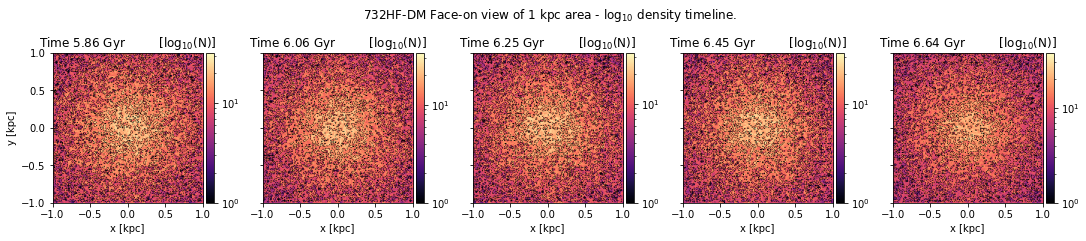

In [ ]:
# Models
#model = "761"
model = "732HF"
nuclear = True
log = True

if model == "761":
    bin_width = 0.3
    xlim,ylim = 10,10 #kpc
    step = 1
    dm = True
elif model == "732HF":
    if nuclear:
        # Nuclear bar
        bin_width = 0.03
        xlim,ylim = 1,1 #kpc
    else:
        # Primary bar
        bin_width = 0.3
        xlim,ylim = 10,10 #kpc
    step = 4
    dm = True

bins = 100
cmap = 'magma'
plt_title = ' Face-on view of ' + str(xlim) + ' kpc area' + ' - log$_{10}$ density timeline.'

iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

panels = iter

figsize_x = 3*panels
figsize_y = 3.5

# make the figure and sub plots
fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))

i = 0
j = 0

for snap in snap_lst:

    if j in iter_lst:
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        s = pbload(base_dir + snap,param_fname,nuclear,log)
      
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        if dm:
            stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.d['x'], s.d['y'], s.d['z'],
                                statistic = 'count',
                                range = [[-xlim,xlim],[-ylim,ylim]],
                                bins = bins)
        else:
            stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                statistic = 'count',
                                range = [[-xlim,xlim],[-ylim,ylim]],
                                bins = bins)

        image = axes[i].imshow(stat2d.T, 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
        xcent = (xedges[1:] + xedges[:-1]) / 2
        ycent = (yedges[1:] + yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
        splt_title = 'Time ' + str(age) + ' Gyr' + '         [log$_{10}$(N)]'
        axes[i].title.set_text(splt_title)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(image, cax=cax, orientation='vertical')
        #cbar.set_label(cbar_label_lst[i])
        if i > 0:
            axes[i].set_yticklabels([])
        i += 1
        j += 1
    else: 
        j += 1

if model == "732HF":
    model == snap.replace(".gz","")

if dm:
    model = model + "-DM"

plt_title = model + plt_title
model_title = model

fig.tight_layout()
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel = 'x [kpc]')
plt.setp(axes[0], ylabel = 'y [kpc]')
plt.savefig(image_dir + model_title + '_face_on_num_density_' + str(xlim) + 'kpc' + '.png')
print('* Done!')
plt.show()


#### Density maps by age group and ellipticity tables

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01310.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 166.42374027934565 degrees
* Snap max age - 6.55Gyr.
** Total stars in snap -  9296457
*** Stars in age group 1  -  1641024
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.1
***** Radius - 0.03 kpc, ellipticity - 0.09
***** Radius - 0.04 kpc, ellipticity - 0.11
***** Radius - 0.05 kpc, ellipticity - 0.11
***** Radius - 0.06 kpc, ellipticity - 0.12
***** Radius - 0.07 kpc, ellipticity - 0.12
***** Radius - 0.08 kpc, ellipticity - 0.13
***** Radius - 0.09 kpc, ellipticity - 0.14
***** Radius - 0.1 kpc, ellipticity - 0.16
***** Radius - 0.11 kpc, ellipticity - 0.17
***** Radius - 0.12 kpc, ellipticity - 0.19
***** Radius - 0.13 kpc, ellipticity - 0.22
***** Radius - 0.14 kpc, ellipticity - 0.24
***** Radius - 0.15 kpc, ellipticity - 0.26
***** Radius - 0.16 kpc, ellipticity - 0.28
****

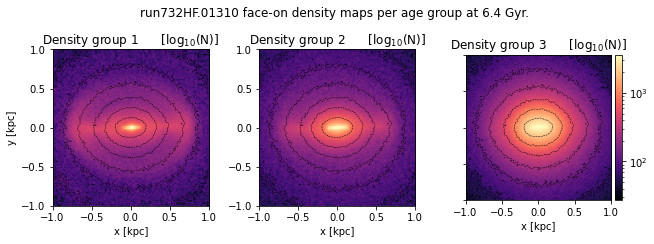

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01320.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 110.8280649012885 degrees
* Snap max age - 6.6Gyr.
** Total stars in snap -  9328025
*** Stars in age group 1  -  1645674
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.0
***** Radius - 0.03 kpc, ellipticity - 0.03
***** Radius - 0.04 kpc, ellipticity - 0.03
***** Radius - 0.05 kpc, ellipticity - 0.04
***** Radius - 0.06 kpc, ellipticity - 0.05
***** Radius - 0.07 kpc, ellipticity - 0.06
***** Radius - 0.08 kpc, ellipticity - 0.07
***** Radius - 0.09 kpc, ellipticity - 0.08
***** Radius - 0.1 kpc, ellipticity - 0.1
***** Radius - 0.11 kpc, ellipticity - 0.11
***** Radius - 0.12 kpc, ellipticity - 0.13
***** Radius - 0.13 kpc, ellipticity - 0.16
***** Radius - 0.14 kpc, ellipticity - 0.18
***** Radius - 0.15 kpc, ellipticity - 0.21
***** Radius - 0.16 kpc, ellipticity - 0.23
***** R

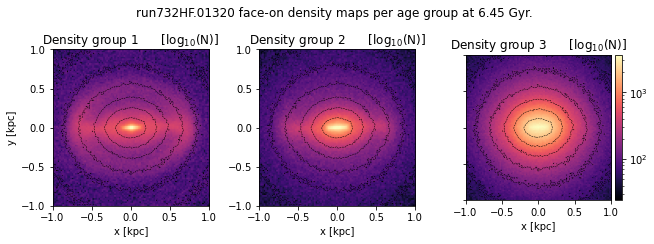

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01330.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by -139.326713107907 degrees
* Snap max age - 6.65Gyr.
** Total stars in snap -  9359476
*** Stars in age group 1  -  1648451
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.04
***** Radius - 0.03 kpc, ellipticity - 0.04
***** Radius - 0.04 kpc, ellipticity - 0.05
***** Radius - 0.05 kpc, ellipticity - 0.06
***** Radius - 0.06 kpc, ellipticity - 0.07
***** Radius - 0.07 kpc, ellipticity - 0.08
***** Radius - 0.08 kpc, ellipticity - 0.09
***** Radius - 0.09 kpc, ellipticity - 0.11
***** Radius - 0.1 kpc, ellipticity - 0.12
***** Radius - 0.11 kpc, ellipticity - 0.15
***** Radius - 0.12 kpc, ellipticity - 0.17
***** Radius - 0.13 kpc, ellipticity - 0.2
***** Radius - 0.14 kpc, ellipticity - 0.23
***** Radius - 0.15 kpc, ellipticity - 0.25
***** Radius - 0.16 kpc, ellipticity - 0.27
*****

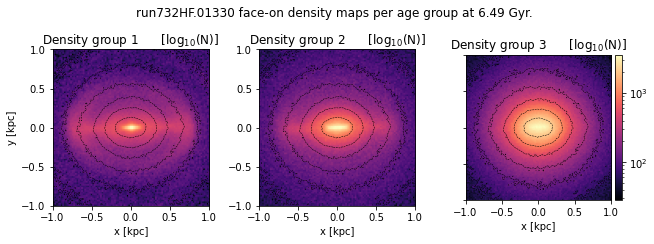

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01340.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 142.56677533893594 degrees
* Snap max age - 6.7Gyr.
** Total stars in snap -  9390966
*** Stars in age group 1  -  1653455
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.06
***** Radius - 0.03 kpc, ellipticity - 0.06
***** Radius - 0.04 kpc, ellipticity - 0.06
***** Radius - 0.05 kpc, ellipticity - 0.06
***** Radius - 0.06 kpc, ellipticity - 0.08
***** Radius - 0.07 kpc, ellipticity - 0.08
***** Radius - 0.08 kpc, ellipticity - 0.09
***** Radius - 0.09 kpc, ellipticity - 0.09
***** Radius - 0.1 kpc, ellipticity - 0.1
***** Radius - 0.11 kpc, ellipticity - 0.12
***** Radius - 0.12 kpc, ellipticity - 0.13
***** Radius - 0.13 kpc, ellipticity - 0.16
***** Radius - 0.14 kpc, ellipticity - 0.18
***** Radius - 0.15 kpc, ellipticity - 0.21
***** Radius - 0.16 kpc, ellipticity - 0.23
*****

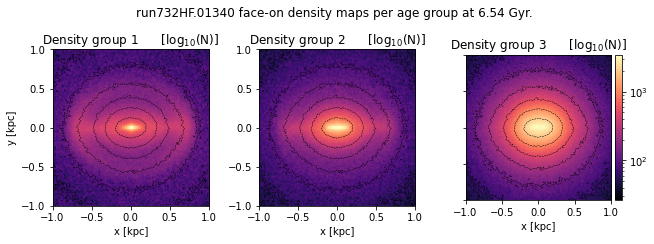

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01350.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 56.69392421602027 degrees
* Snap max age - 6.75Gyr.
** Total stars in snap -  9422484
*** Stars in age group 1  -  1657425
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.08
***** Radius - 0.03 kpc, ellipticity - 0.1
***** Radius - 0.04 kpc, ellipticity - 0.09
***** Radius - 0.05 kpc, ellipticity - 0.09
***** Radius - 0.06 kpc, ellipticity - 0.1
***** Radius - 0.07 kpc, ellipticity - 0.12
***** Radius - 0.08 kpc, ellipticity - 0.13
***** Radius - 0.09 kpc, ellipticity - 0.14
***** Radius - 0.1 kpc, ellipticity - 0.16
***** Radius - 0.11 kpc, ellipticity - 0.17
***** Radius - 0.12 kpc, ellipticity - 0.19
***** Radius - 0.13 kpc, ellipticity - 0.22
***** Radius - 0.14 kpc, ellipticity - 0.25
***** Radius - 0.15 kpc, ellipticity - 0.27
***** Radius - 0.16 kpc, ellipticity - 0.29
***** 

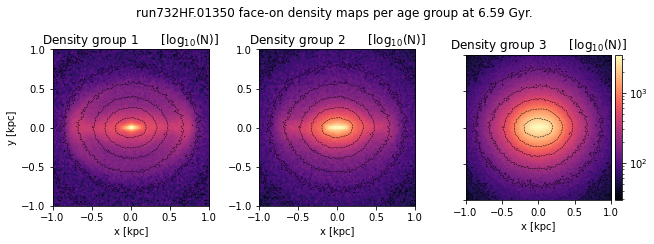

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01360.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 143.23408430719695 degrees
* Snap max age - 6.8Gyr.
** Total stars in snap -  9453550
*** Stars in age group 1  -  1660440
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.02
***** Radius - 0.03 kpc, ellipticity - 0.02
***** Radius - 0.04 kpc, ellipticity - 0.02
***** Radius - 0.05 kpc, ellipticity - 0.03
***** Radius - 0.06 kpc, ellipticity - 0.03
***** Radius - 0.07 kpc, ellipticity - 0.04
***** Radius - 0.08 kpc, ellipticity - 0.05
***** Radius - 0.09 kpc, ellipticity - 0.06
***** Radius - 0.1 kpc, ellipticity - 0.07
***** Radius - 0.11 kpc, ellipticity - 0.09
***** Radius - 0.12 kpc, ellipticity - 0.12
***** Radius - 0.13 kpc, ellipticity - 0.14
***** Radius - 0.14 kpc, ellipticity - 0.17
***** Radius - 0.15 kpc, ellipticity - 0.2
***** Radius - 0.16 kpc, ellipticity - 0.22
*****

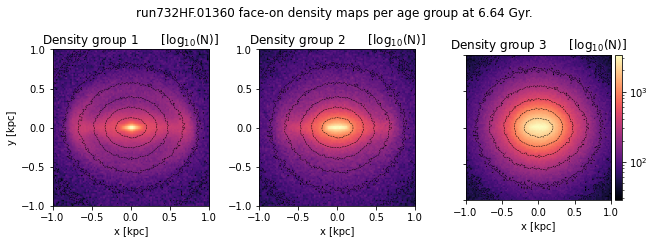

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01370.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by -136.71586237504093 degrees
* Snap max age - 6.85Gyr.
** Total stars in snap -  9484546
*** Stars in age group 1  -  1664028
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.02
***** Radius - 0.03 kpc, ellipticity - 0.04
***** Radius - 0.04 kpc, ellipticity - 0.04
***** Radius - 0.05 kpc, ellipticity - 0.04
***** Radius - 0.06 kpc, ellipticity - 0.04
***** Radius - 0.07 kpc, ellipticity - 0.05
***** Radius - 0.08 kpc, ellipticity - 0.06
***** Radius - 0.09 kpc, ellipticity - 0.06
***** Radius - 0.1 kpc, ellipticity - 0.08
***** Radius - 0.11 kpc, ellipticity - 0.09
***** Radius - 0.12 kpc, ellipticity - 0.11
***** Radius - 0.13 kpc, ellipticity - 0.14
***** Radius - 0.14 kpc, ellipticity - 0.16
***** Radius - 0.15 kpc, ellipticity - 0.19
***** Radius - 0.16 kpc, ellipticity - 0.21
**

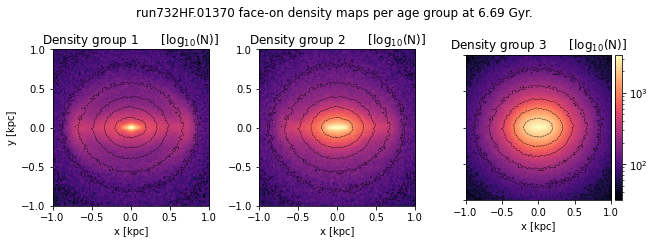

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01380.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 114.52537976815361 degrees
* Snap max age - 6.9Gyr.
** Total stars in snap -  9514870
*** Stars in age group 1  -  1665253
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.05
***** Radius - 0.03 kpc, ellipticity - 0.08
***** Radius - 0.04 kpc, ellipticity - 0.09
***** Radius - 0.05 kpc, ellipticity - 0.09
***** Radius - 0.06 kpc, ellipticity - 0.08
***** Radius - 0.07 kpc, ellipticity - 0.09
***** Radius - 0.08 kpc, ellipticity - 0.09
***** Radius - 0.09 kpc, ellipticity - 0.1
***** Radius - 0.1 kpc, ellipticity - 0.11
***** Radius - 0.11 kpc, ellipticity - 0.12
***** Radius - 0.12 kpc, ellipticity - 0.13
***** Radius - 0.13 kpc, ellipticity - 0.15
***** Radius - 0.14 kpc, ellipticity - 0.18
***** Radius - 0.15 kpc, ellipticity - 0.2
***** Radius - 0.16 kpc, ellipticity - 0.22
***** 

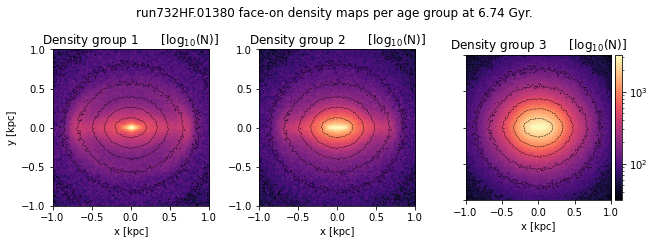

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01390.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 178.8497506645919 degrees
* Snap max age - 6.95Gyr.
** Total stars in snap -  9544868
*** Stars in age group 1  -  1668464
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.1
***** Radius - 0.03 kpc, ellipticity - 0.09
***** Radius - 0.04 kpc, ellipticity - 0.07
***** Radius - 0.05 kpc, ellipticity - 0.09
***** Radius - 0.06 kpc, ellipticity - 0.09
***** Radius - 0.07 kpc, ellipticity - 0.1
***** Radius - 0.08 kpc, ellipticity - 0.1
***** Radius - 0.09 kpc, ellipticity - 0.12
***** Radius - 0.1 kpc, ellipticity - 0.13
***** Radius - 0.11 kpc, ellipticity - 0.15
***** Radius - 0.12 kpc, ellipticity - 0.17
***** Radius - 0.13 kpc, ellipticity - 0.19
***** Radius - 0.14 kpc, ellipticity - 0.22
***** Radius - 0.15 kpc, ellipticity - 0.25
***** Radius - 0.16 kpc, ellipticity - 0.27
***** R

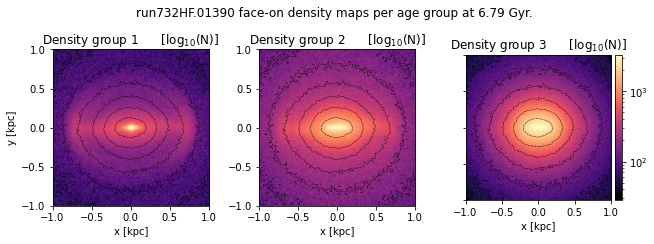

In [ ]:
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 100
cmap = 'magma'
plt_title = ' face-on density maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]',
                  'σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3

# Figure 8 - 10
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Appendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]
pa_lst = [45,80,90,170,90,120,95,185,75,155,15,45,30,26,0,27,135,10,85,5]

div_lst = [1/3]

per_radius = True

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload_nuclear(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        pa = pa_lst[j]
        #if pa != 0:
        #    s.rotate_z(-pa)
        #    print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
            
        for incl in incl_lst:
    
            stat2d_lst = []

            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
            # Divide snapshot into 3 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr.')
            print('** Total stars in snap - ', len(s.star))
            
            # Number density statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            age_grp = 0
            for divlr in divlr_lst:
                age_grp += 1
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]
                print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
                
                # Number density statistics face-on for stellar population by age group
                dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(dfg_stat2d.T)
            
                s_xaxis = []
                s_yaxis = [0]*bins

                for e in dfg_stat2d:
                    s_xaxis.append(sum(e))
                    s_yaxis = s_yaxis + e
            
                r_lst = []
                unit = 2*xlim/bins

                for iter in range (0, int(bins/2)):
                    r = xlim - unit*iter
                    r_lst.append(r)
                #print(r_lst)

                for iter in range (0, int(bins/2)):
                    r = unit + unit*iter
                    r_lst.append(r)
                #print(r_lst)

                if per_radius:
                    print('*** Age group -', age_grp)
                
                    for bin in range (2, bins):
                        q_x = 0
                        q_y = 0

                        for iter in range (0, bin - 1):
                            q_y = q_y + s_yaxis[iter]*(r_lst[iter]**2)
                            q_x = q_x + s_xaxis[iter]*(r_lst[iter]**2)

                        e = 1- sqrt(q_y / q_x)

                        print('***** Radius -',round(unit*bin/2,2), 'kpc, ellipticity -',round(e,2))

                q_x = 0
                q_y = 0

                for iter in range (0, bins - 1):
                    q_y = q_y + s_yaxis[iter]*(r_lst[iter]**2)
                    q_x = q_x + s_xaxis[iter]*(r_lst[iter]**2)

                e = 1- sqrt(q_y / q_x)

                print('*** Age group', age_grp, 'ellipticity -',round(e,2))

            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            for i in range(x_panels):
                        image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                        xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                        ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                        axes[i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                        axes[i].title.set_text(splt_title_lst[i])

            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])

            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_density_by_age_3grp_' + str(xlim) + 'kpc' + '.png')
            print('**** Done!')
            plt.show()
            
        j += 1

#### Test functions on sample data

In [2]:
# Example usage
list1 = [[1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [9, 10, 11, 12, 13, 12, 11, 10, 9, 8],
        [10, 10, 150, 160, 170, 160, 150, 140, 10, 10],
        [131, 141, 151, 161, 171, 161, 151, 141, 131, 121],
        [132, 142, 152, 162, 172, 162, 152, 142, 132, 122],
        [10, 10, 150, 160, 170, 160, 150, 140, 10, 10],
        [9, 10, 11, 12, 13, 12, 11, 10, 9, 8],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0]]

list2 = [[1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [131, 141, 151, 161, 171, 161, 151, 141, 131, 121],
        [132, 142, 152, 162, 172, 162, 152, 142, 132, 122],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0]]

list3 = [[1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [5, 6, 7, 8, 9, 8, 7, 6, 5, 4],
        [1, 2, 3, 4, 5, 4, 3, 2, 1, 0]]

list = list2

#m = 2  # Size of the sub-list
#sub_list = extract_sublist(list, m)
#print(sub_list)

#row_sums, col_sums = sum_columns_and_rows(list)
#print("Row sums:", row_sums)
#print("Column sums:", col_sums)

xlim = 1
bins = 10
unit = 2*xlim/bins
print("Unit in kpc:", unit)

e = ellipticity(unit,bins,list)

print('*** Age group:', "1,", 'ellipticity:', e)

e_list = []
r_list = []

for radius in range(1,int(bins/2)+1):
    sub_list = extract_sublist(list, radius)
    e = ellipticity(unit,2*radius,sub_list)
    e_list.append(e)
    r_list.append(round(radius*unit,2))
    print('*** Radius:', round(radius*unit,2), " kpc, ", 'ellipticity:', e)

print("Radii:",r_list)
print("Ellipticities:",e_list)


Unit in kpc: 0.2
*** Age group: 1, ellipticity: -0.84
*** Radius: 0.2  kpc,  ellipticity: -0.02
*** Radius: 0.4  kpc,  ellipticity: -0.33
*** Radius: 0.6  kpc,  ellipticity: -0.54
*** Radius: 0.8  kpc,  ellipticity: -0.71
*** Radius: 1.0  kpc,  ellipticity: -0.84
Radii: [0.2, 0.4, 0.6, 0.8, 1.0]
Ellipticities: [-0.02, -0.33, -0.54, -0.71, -0.84]


/tmp/ipykernel_460/850886250.py:230: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  col_sums = [sum(matrix[i][j] for i in range(num_rows)) for j in range(num_cols)]


#### Bar length calculation

Data from:  run761AV.02000.gz
from Jbook /home/ubuntu/projects/S2B/models/SB_nogas_models/run761AV.02000.gz /home/ubuntu/projects/S2B/models/SB_nogas_models/run761AV.02000.param False False True
* Loading data from file /home/ubuntu/projects/S2B/models/SB_nogas_models/run761AV.02000.gz ...
* Centering the data...
Data from  run761AV.02000.gz


/tmp/ipykernel_28516/510763897.py:73: RuntimeWarning: invalid value encountered in divide
  a2_plot = np.hypot(s2p_sum, c2p_sum)/mass


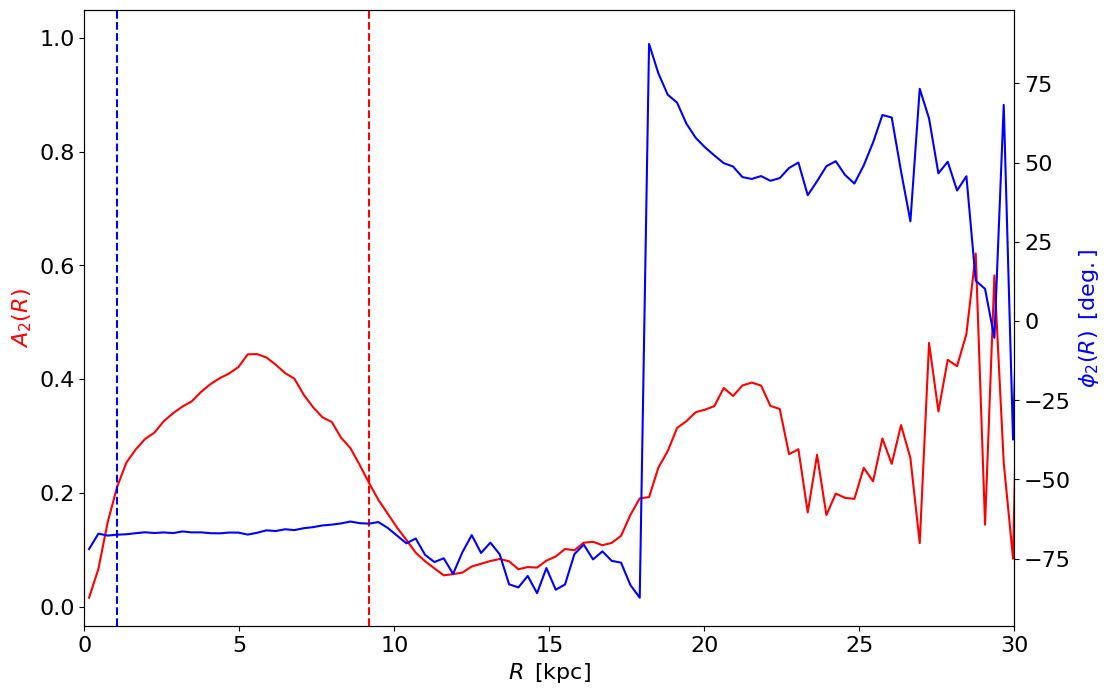

For model 761AV, the amp bar ends at R = 1.05 koc
For model 761AV, the phase bar ends at R = 9.18 kpc


In [5]:
"""
Calculates and stores in an npy file the bar radial extent by time
using a2 and phi2
"""

import os, numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.signal import find_peaks

bin_width = 0.3

model = '761AV'

master_folder = base_dir
os.chdir(master_folder)

output_folder = image_dir

# =================================================
# This file contains the model with the bar along x
# =================================================

#fname = '7611AV20_stars.npy' # Stuart file format, already aligned with x-axis

fname = "run761AV.02000.gz"
param_fname = "run761AV.02000.param"
print('Data from: ',fname)

Data = None

#Load the core model dat from a .npy file - Stuart way
#Data = np.load(os.path.join(master_folder, fname))

# Load snapshot data, center face-on, align primary bar using inertia tensor
Data = pbload(base_dir + fname,base_dir + param_fname,log = True)

print('Data from ', fname)

#Extract phase space data for the model for stars
y, x, m = Data.s['y'], Data.s['x'], Data.s['mass']

#print("Mass sum:", m.sum())
#print("Mass array:", m)

#Capture the radius of each particle and its cylindrical angle phi
R_plot = np.hypot(x, y)
phis = np.arctan2(y, x)

bins = int(R_plot.max()/bin_width)

#Plot the amplitude diagram first
xlab = r'$R \rm \enspace [kpc]$'
ylab = r'$A_2(R)$'
y2lab = r'$\phi_2(R) \enspace \rm [deg.]$'

s2p = np.sin(2*phis)
c2p = np.cos(2*phis)
   
# For each angular bin calculate the bar amp and phase angle
s2p_binned = stats.binned_statistic(R_plot, m * s2p, 'sum', bins=bins)
c2p_binned = stats.binned_statistic(R_plot, m * c2p, 'sum', bins=bins)
mass_binned = stats.binned_statistic(R_plot, m, 'sum', bins=bins)

s2p_sum = s2p_binned.statistic.T
c2p_sum = c2p_binned.statistic.T
mass = mass_binned.statistic.T


# With Chiara (Nov 2020) we need a factor 1/m (=1/2) for the phase angle of the bar
phi2_plot = 0.5 * np.degrees(np.arctan2(s2p_sum, c2p_sum))
a2_plot = np.hypot(s2p_sum, c2p_sum)/mass

# Find midpoint of the bins
radial_bins = s2p_binned.bin_edges[:-1] + np.diff(s2p_binned.bin_edges)/2


# We wish to locate where, after the initial settling, phi2 changes
# from constant by more than 10 degrees
# Set initial settling to be R = 1kpc and extract the first time the
# absolute value goes above 10 degrees - this is the extent of the bar
bar_ends_phi2_criterion = 10
bar_ends_phi2 = phi2_plot[(radial_bins > 1) & (abs(phi2_plot) >= 
                           bar_ends_phi2_criterion)][0]
bar_ends_R_phi2 = radial_bins[(radial_bins > 1) & (abs(phi2_plot) >= 
                          bar_ends_phi2_criterion)][0]

# A low estimate for the bar would be half the a2 peak
# The a2 peak is the first peak in the plot
# Then find the half peak and its location
a2_peaks, _ = find_peaks(a2_plot) 
a2_max = a2_plot[a2_peaks[0]]

a2_max_R = radial_bins[a2_peaks[0]]
bar_ends_a2_criterion = 2

# If this criteria is met then we do not have a bar
if len(radial_bins[(radial_bins > a2_max_R) & 
    (a2_plot <= a2_max/bar_ends_a2_criterion)]) == 0:
    bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
# If the bar amplitude a2_max falls below 0.2 then consider the bar unformed
# and set the radii to be nan
elif a2_max < 0.2:
    bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
else:
    bar_ends_R_a2 = radial_bins[(radial_bins > a2_max_R) & 
                            (a2_plot <= a2_max/bar_ends_a2_criterion)][0]
   
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
ax = axes
ax2 = ax.twinx()
fs = 16

ax.plot(radial_bins, a2_plot, c='r', label='r$A_2(R)$')
ax2.plot(radial_bins, phi2_plot, c='b', label='r$\phi_2(R)$')
ax.tick_params(axis='both', which='both', labelsize=fs)
ax2.tick_params(axis='both', which='both', labelsize=fs)
ax.set_xlabel(xlab, fontsize=fs)
ax.set_ylabel(ylab, fontsize=fs, c='r')
ax2.set_ylabel(y2lab, fontsize=fs, c='b')
ax.axvline(bar_ends_R_a2, c='r', ls='--')
ax.axvline(bar_ends_R_phi2, c='b', ls='--')
ax.set_xlim(0., 30.)

plt.show()

print('For model {0}, the amp bar ends at R = {1} koc'.format(model, round(bar_ends_R_phi2, 2) ))
print('For model {0}, the phase bar ends at R = {1} kpc'.format(model, round(bar_ends_R_a2, 2) ))

#### Bar length calculation 2

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 66.46089836336266 degrees
The bar amplitude is 0.17 - below 0.2.
For model run732HF.01200, the amp bar ends at R = nan kpc
For model run732HF.01200, the phase bar ends at R = nan kpc


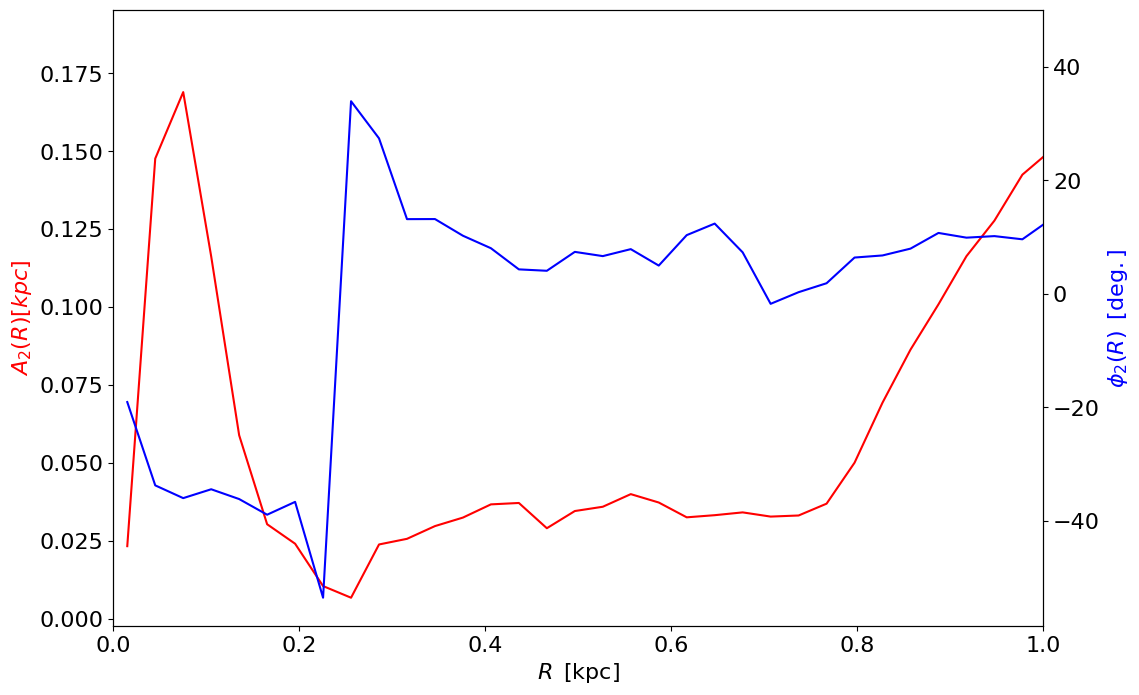

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 148.42317136556196 degrees
The bar amplitude is 0.17 - below 0.2.
For model run732HF.01210, the amp bar ends at R = nan kpc
For model run732HF.01210, the phase bar ends at R = nan kpc


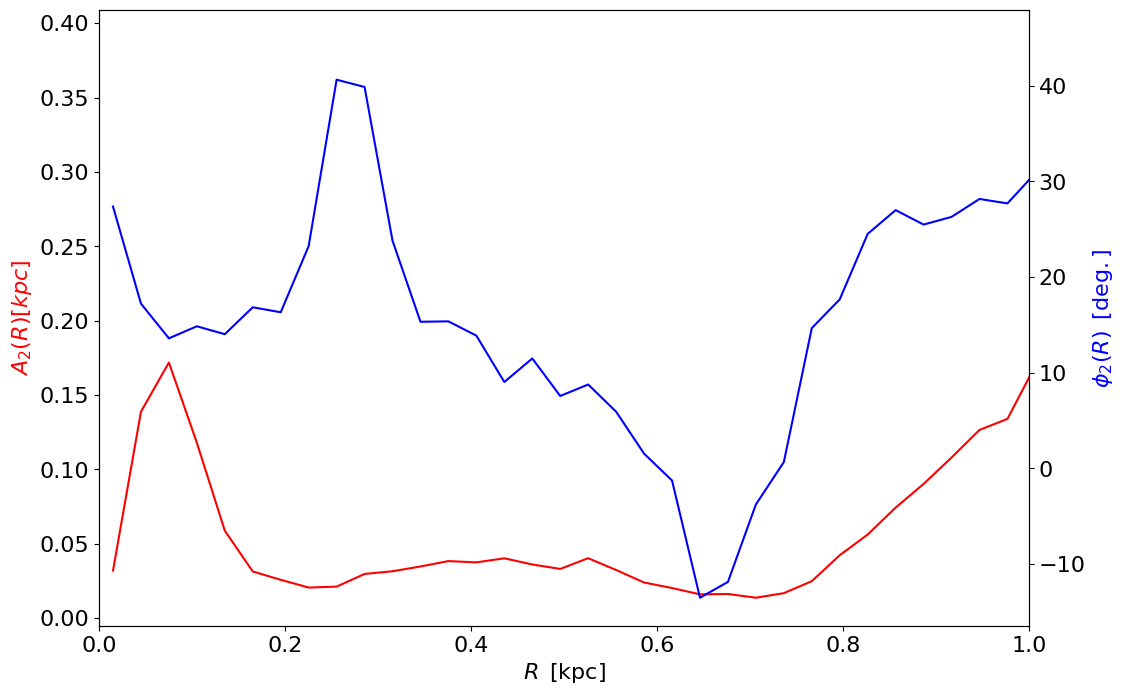

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 57.64346093283681 degrees
The bar amplitude is 0.16 - below 0.2.
For model run732HF.01220, the amp bar ends at R = nan kpc
For model run732HF.01220, the phase bar ends at R = nan kpc


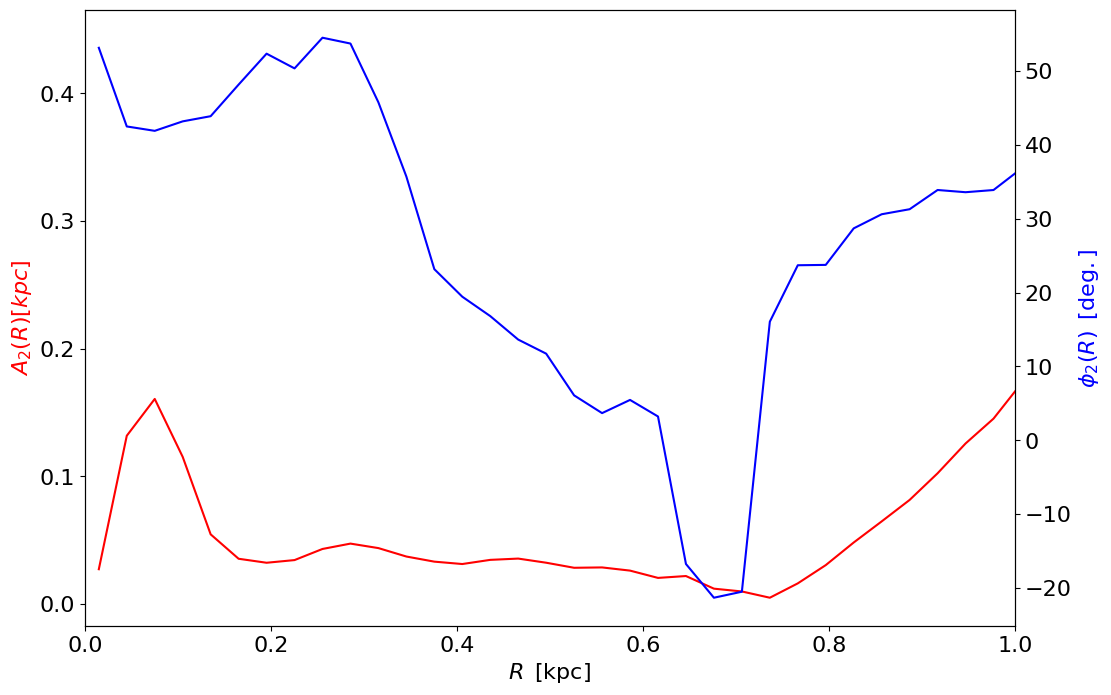

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01230.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 101.13427200135065 degrees
The bar amplitude is 0.16 - below 0.2.
For model run732HF.01230, the amp bar ends at R = nan kpc
For model run732HF.01230, the phase bar ends at R = nan kpc


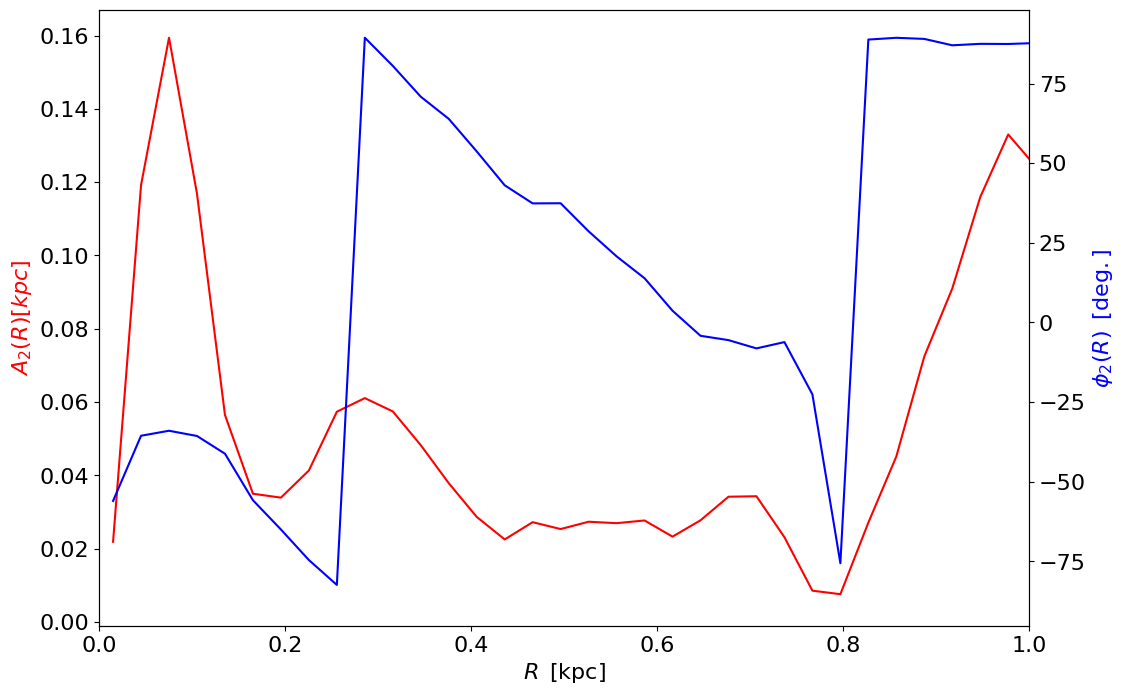

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01240.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 142.74037538452404 degrees
The bar amplitude is 0.15 - below 0.2.
For model run732HF.01240, the amp bar ends at R = nan kpc
For model run732HF.01240, the phase bar ends at R = nan kpc


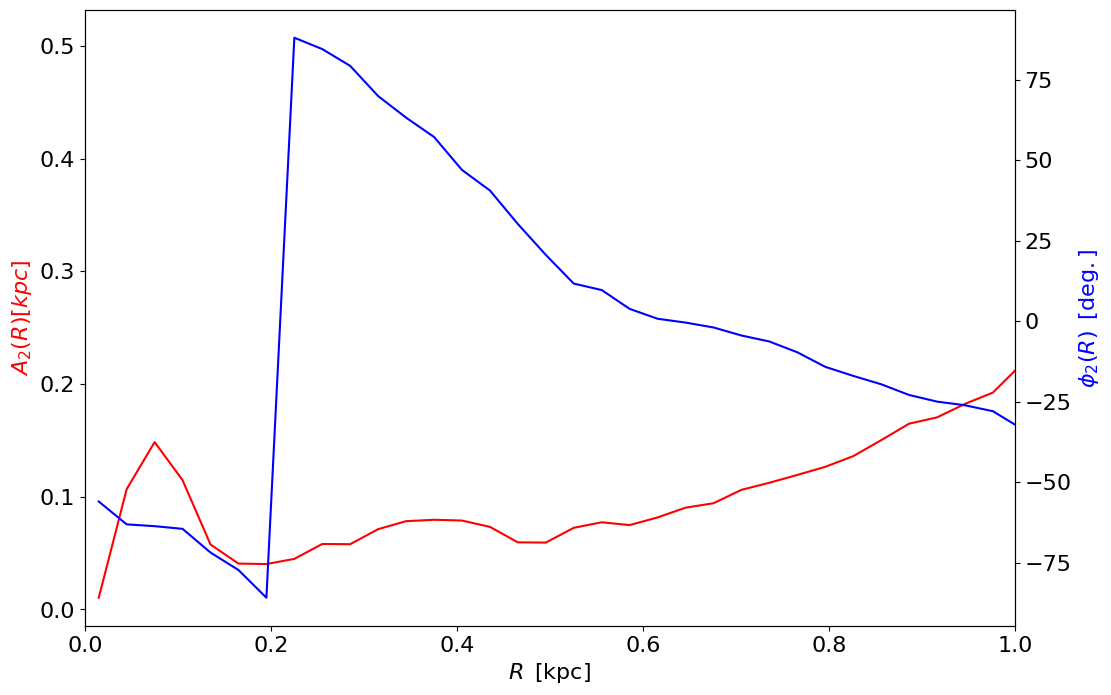

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01250.gz ...
* Centering the data...


In [2]:
#bins = 20

plotting = True

# Models
model = "761"
model = "732HF"

if model == "761":
    bin_width = 0.3
    xlim,ylim = 30,30 #kpc
elif model == "732HF":
    bin_width = 0.03
    xlim,ylim = 1,1 #kpc

for snap in snap_lst:
              
    # Load snapshot data, center face-on, align primary bar using inertia tensor
    snap_name = snap.replace('.gz','')
    param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
    #print(param_fname[0])

    if model == "761":
        #run761AV
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
    elif model == "732HF":
        #run732HF
        sim = pbload_nuclear(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)

        # Define conditions for sub-array extraction
        condition_x = (sim['x'] > -xlim) & (sim['x'] < xlim)
        condition_y = (sim['y'] > -ylim) & (sim['y'] < ylim)

        # Apply conditions to extract sub-array
        s = sim[(condition_x) & (condition_y)]
    else:
        print("No model is specified. Exiting without bar length calculations.")
        exit()

    bar_length(s,snap,bin_width,xlim,plotting)

    del s


#### Density maps by age group and ellipticity plots

In [3]:
# Zoom in
xlim, ylim = 1, 1 #kpc

# For bar ellipticity calculations
bins = 30

cmap = 'magma'
plt_title = ' face-on density maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]',
                  'Ellipticity by R group 1       [kpc]',
                  'Ellipticity by R group 2       [kpc]',
                  'Ellipticity by R group 3       [kpc]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'R [kpc]',
                  'R [kpc]',
                  'R [kpc]']

per_radius = True
per_radius = False

plot = True
plot = False
save_plot = True
save_plot = False

x_panels = 3
y_panels = 2

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

div = 1/3

for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        s = pbload_nuclear(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        stat2d_lst = []

        # Divide snapshot into 3 age groups
        max_age = round(max(s.star['age']),2)
        print('* Snap max age - ' + str(max_age) + 'Gyr.')
        print('** Total stars in snap - ', len(s.star))
            
        # Number density statistics per age group
        divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]

        if per_radius:
            # List of ellipticities per age group
            e_list = [[],[],[]]

        age_grp = 0

        for divlr in divlr_lst:
            age_grp += 1
            div_l = divlr[0]
            div_r = divlr[1]
            # Mask stars between age dividers div_l and div_r
            mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
            # print(len(mask))
            s_grp = s.star[mask]
            print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
                
            # Number density statistics face-on for stellar population by age group to calculate ellipticity
            dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(dfg_stat2d.T)
            
            #list = dfg_stat2d
            unit = 2*xlim/bins
            print("Unit in kpc:", round(unit,2))
            e = ellipticity(unit,bins,dfg_stat2d)
            print('*** Age group:', age_grp, 'ellipticity:', round(e,2))

            if per_radius:
                # e_list is defined above the age grouping loop
                r_list = []
                for radius in range(1,int(bins/2)+1):
                    sub_list = extract_sublist(dfg_stat2d, radius)
                    e = ellipticity(unit,2*radius,sub_list)
                    e_list[age_grp-1].append(e)
                    r_list.append(round(radius*unit,2))
                    print('*** Radius:', round(radius*unit,2), " kpc, ", 'ellipticity:', e)

        if plot:
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
        
            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
            for k in range(y_panels):
                    for i in range(x_panels):
                        if k == 0:
                            image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                                origin = 'lower',
                                extent = [-xlim, xlim, -ylim, ylim ],
                                norm = LogNorm(),
                                cmap = cmap)
                            xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                            ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                            axes[k,i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                            axes[k,i].title.set_text(splt_title_lst[3*k+i])
                        else:
                            image = axes[k,i].plot(r_list,e_list[i])
                            axes[k,i].title.set_text(splt_title_lst[3*k+i])
                            # axes[k,i].set_ylim(min(e_list[age_grp-1]), max(e_list[age_grp-1]))
                    
                        divider = make_axes_locatable(axes[k,i])
                        #cax = divider.append_axes('right', size='5%', pad=0.05)
                        #cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                        #cbar.set_label(cbar_label_lst[i])
                        if k == 0 and i > 0:
                            axes[k,i].set_yticklabels([])

            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr.')
            plt.setp(axes[0,:], xlabel = 'x [kpc]')
            plt.setp(axes[1,:], xlabel = 'R [kpc]')
            plt.setp(axes[0,0], ylabel = 'y [kpc]')
            plt.setp(axes[1,0], ylabel = 'e')
            plt.show()
            if save_plot:
                plt.savefig(image_dir + snap.replace(".gz","") + '_dens_ellipt_by_age_3grp_' + str(xlim) + 'kpc' + '.png')
        
        del stat2d_lst
        print('**** Done for snapshot', snap_name)
        print()
            


* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 66.46089836336266 degrees
* Snap max age - 6.0Gyr.
** Total stars in snap -  8926936
*** Stars in age group 1  -  1604410
Unit in kpc: 0.06666666666666667
*** Age group: 1 ellipticity: -0.18
*** Stars in age group 2  -  2385751


/tmp/ipykernel_3034/4265010105.py:245: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  col_sums = [sum(matrix[i][j] for i in range(num_rows)) for j in range(num_cols)]


Unit in kpc: 0.06666666666666667
*** Age group: 2 ellipticity: -0.03
*** Stars in age group 3  -  4936358
Unit in kpc: 0.06666666666666667
*** Age group: 3 ellipticity: 0.02
**** Done for snapshot run732HF.01200

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Aligning the  data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 148.42317136558881 degrees
* Snap max age - 6.05Gyr.
** Total stars in snap -  8960917
*** Stars in age group 1  -  1604977
Unit in kpc: 0.06666666666666667
*** Age group: 1 ellipticity: 0.07
*** Stars in age group 2  -  2393218
Unit in kpc: 0.06666666666666667
*** Age group: 2 ellipticity: 0.09
*** Stars in age group 3  -  4962281
Unit in kpc: 0.06666666666666667
*** Age group: 3 ellipticity: 0.04
**** Done for snapshot run732HF.01210

* Loading data from the file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Alignin

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656133 degrees
* Rotating the primary bar to PA 45 deg.
* Snap max age - 6.0Gyr.
** Total stars in snap -  8926936
*** Stars in age group 1  -  1604410
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - -0.14
***** Radius - 0.03 kpc, ellipticity - -0.15
***** Radius - 0.04 kpc, ellipticity - -0.18
***** Radius - 0.05 kpc, ellipticity - -0.19
***** Radius - 0.06 kpc, ellipticity - -0.21
***** Radius - 0.07 kpc, ellipticity - -0.21
***** Radius - 0.08 kpc, ellipticity - -0.2
***** Radius - 0.09 kpc, ellipticity - -0.2
***** Radius - 0.1 kpc, ellipticity - -0.2
***** Radius - 0.11 kpc, ellipticity - -0.2
***** Radius - 0.12 kpc, ellipticity - -0.21
***** Radius - 0.13 kpc, ellipticity - -0.2
***** Radius - 0.14 kpc, ellipticity - -0.2
***** Radius - 0.15 kpc, ellipticity - -

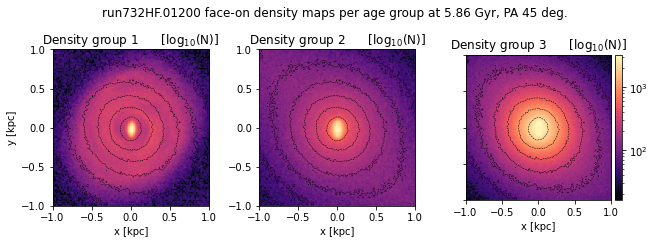

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 174.59931084286313 degrees
* Rotating the primary bar to PA 80 deg.
* Snap max age - 6.05Gyr.
** Total stars in snap -  8960917
*** Stars in age group 1  -  1604977
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.14
***** Radius - 0.03 kpc, ellipticity - 0.15
***** Radius - 0.04 kpc, ellipticity - 0.17
***** Radius - 0.05 kpc, ellipticity - 0.2
***** Radius - 0.06 kpc, ellipticity - 0.22
***** Radius - 0.07 kpc, ellipticity - 0.23
***** Radius - 0.08 kpc, ellipticity - 0.25
***** Radius - 0.09 kpc, ellipticity - 0.26
***** Radius - 0.1 kpc, ellipticity - 0.27
***** Radius - 0.11 kpc, ellipticity - 0.28
***** Radius - 0.12 kpc, ellipticity - 0.28
***** Radius - 0.13 kpc, ellipticity - 0.29
***** Radius - 0.14 kpc, ellipticity - 0.28
***** Radius - 0.15 kpc, ellipticity - 0.28
**

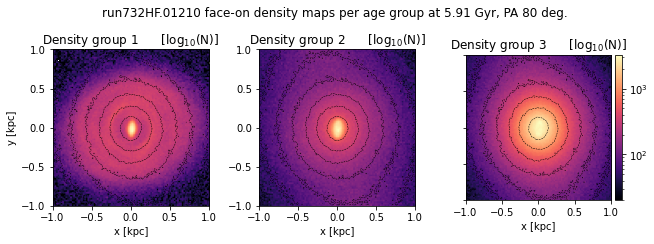

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 88.64641316008235 degrees
* Rotating the primary bar to PA 90 deg.
* Snap max age - 6.1Gyr.
** Total stars in snap -  8993967
*** Stars in age group 1  -  1605996
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.29
***** Radius - 0.03 kpc, ellipticity - 0.3
***** Radius - 0.04 kpc, ellipticity - 0.31
***** Radius - 0.05 kpc, ellipticity - 0.31
***** Radius - 0.06 kpc, ellipticity - 0.33
***** Radius - 0.07 kpc, ellipticity - 0.35
***** Radius - 0.08 kpc, ellipticity - 0.37
***** Radius - 0.09 kpc, ellipticity - 0.38
***** Radius - 0.1 kpc, ellipticity - 0.39
***** Radius - 0.11 kpc, ellipticity - 0.4
***** Radius - 0.12 kpc, ellipticity - 0.42
***** Radius - 0.13 kpc, ellipticity - 0.42
***** Radius - 0.14 kpc, ellipticity - 0.43
***** Radius - 0.15 kpc, ellipticity - 0.43
*****

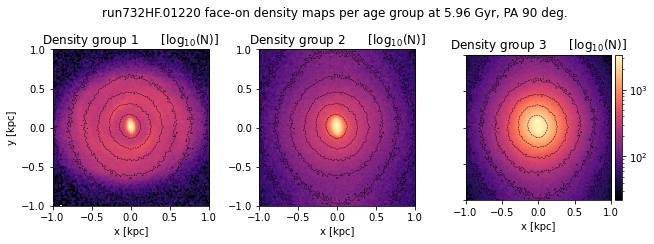

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01230.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -172.62155486404146 degrees
* Rotating the primary bar to PA 170 deg.
* Snap max age - 6.15Gyr.
** Total stars in snap -  9027405
*** Stars in age group 1  -  1606528
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - -0.39
***** Radius - 0.03 kpc, ellipticity - -0.38
***** Radius - 0.04 kpc, ellipticity - -0.41
***** Radius - 0.05 kpc, ellipticity - -0.46
***** Radius - 0.06 kpc, ellipticity - -0.48
***** Radius - 0.07 kpc, ellipticity - -0.51
***** Radius - 0.08 kpc, ellipticity - -0.53
***** Radius - 0.09 kpc, ellipticity - -0.56
***** Radius - 0.1 kpc, ellipticity - -0.58
***** Radius - 0.11 kpc, ellipticity - -0.61
***** Radius - 0.12 kpc, ellipticity - -0.64
***** Radius - 0.13 kpc, ellipticity - -0.67
***** Radius - 0.14 kpc, ellipticity - -0.69
***** Radius - 0.15 kpc, ellip

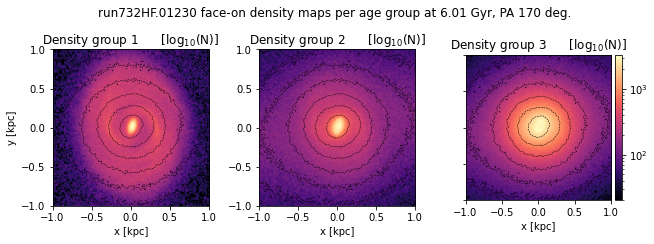

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01240.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 103.69997384566695 degrees
* Rotating the primary bar to PA 90 deg.
* Snap max age - 6.2Gyr.
** Total stars in snap -  9061513
*** Stars in age group 1  -  1609857
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - -0.14
***** Radius - 0.03 kpc, ellipticity - -0.14
***** Radius - 0.04 kpc, ellipticity - -0.15
***** Radius - 0.05 kpc, ellipticity - -0.16
***** Radius - 0.06 kpc, ellipticity - -0.16
***** Radius - 0.07 kpc, ellipticity - -0.15
***** Radius - 0.08 kpc, ellipticity - -0.14
***** Radius - 0.09 kpc, ellipticity - -0.13
***** Radius - 0.1 kpc, ellipticity - -0.12
***** Radius - 0.11 kpc, ellipticity - -0.11
***** Radius - 0.12 kpc, ellipticity - -0.1
***** Radius - 0.13 kpc, ellipticity - -0.09
***** Radius - 0.14 kpc, ellipticity - -0.08
***** Radius - 0.15 kpc, elliptici

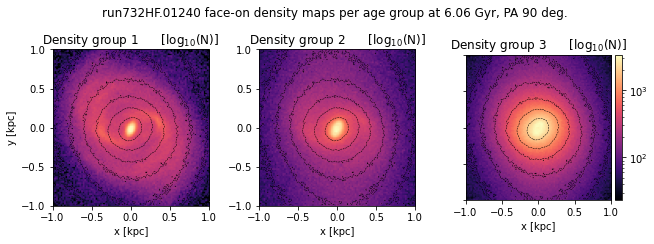

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01250.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -167.08701143655207 degrees
* Rotating the primary bar to PA 120 deg.
* Snap max age - 6.25Gyr.
** Total stars in snap -  9097744
*** Stars in age group 1  -  1614601
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.05
***** Radius - 0.03 kpc, ellipticity - 0.09
***** Radius - 0.04 kpc, ellipticity - 0.14
***** Radius - 0.05 kpc, ellipticity - 0.21
***** Radius - 0.06 kpc, ellipticity - 0.27
***** Radius - 0.07 kpc, ellipticity - 0.3
***** Radius - 0.08 kpc, ellipticity - 0.33
***** Radius - 0.09 kpc, ellipticity - 0.36
***** Radius - 0.1 kpc, ellipticity - 0.39
***** Radius - 0.11 kpc, ellipticity - 0.41
***** Radius - 0.12 kpc, ellipticity - 0.44
***** Radius - 0.13 kpc, ellipticity - 0.46
***** Radius - 0.14 kpc, ellipticity - 0.47
***** Radius - 0.15 kpc, ellipticity - 0.49


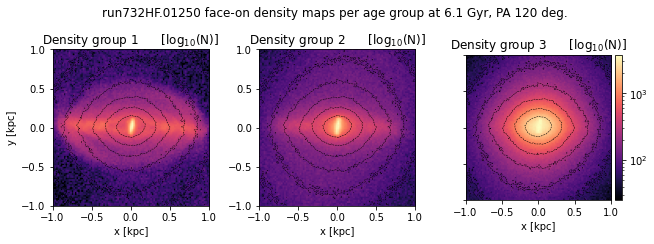

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01260.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 103.18405996483067 degrees
* Rotating the primary bar to PA 95 deg.
* Snap max age - 6.3Gyr.
** Total stars in snap -  9136272
*** Stars in age group 1  -  1623259
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.09
***** Radius - 0.03 kpc, ellipticity - 0.13
***** Radius - 0.04 kpc, ellipticity - 0.16
***** Radius - 0.05 kpc, ellipticity - 0.17
***** Radius - 0.06 kpc, ellipticity - 0.19
***** Radius - 0.07 kpc, ellipticity - 0.2
***** Radius - 0.08 kpc, ellipticity - 0.23
***** Radius - 0.09 kpc, ellipticity - 0.24
***** Radius - 0.1 kpc, ellipticity - 0.26
***** Radius - 0.11 kpc, ellipticity - 0.28
***** Radius - 0.12 kpc, ellipticity - 0.29
***** Radius - 0.13 kpc, ellipticity - 0.31
***** Radius - 0.14 kpc, ellipticity - 0.33
***** Radius - 0.15 kpc, ellipticity - 0.35
***

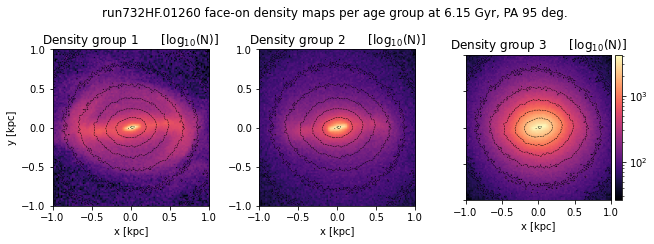

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01270.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 46.97749281066451 degrees
* Rotating the primary bar to PA 185 deg.
* Snap max age - 6.35Gyr.
** Total stars in snap -  9170303
*** Stars in age group 1  -  1628676
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.01
***** Radius - 0.03 kpc, ellipticity - 0.02
***** Radius - 0.04 kpc, ellipticity - 0.04
***** Radius - 0.05 kpc, ellipticity - 0.05
***** Radius - 0.06 kpc, ellipticity - 0.05
***** Radius - 0.07 kpc, ellipticity - 0.06
***** Radius - 0.08 kpc, ellipticity - 0.06
***** Radius - 0.09 kpc, ellipticity - 0.07
***** Radius - 0.1 kpc, ellipticity - 0.08
***** Radius - 0.11 kpc, ellipticity - 0.09
***** Radius - 0.12 kpc, ellipticity - 0.1
***** Radius - 0.13 kpc, ellipticity - 0.11
***** Radius - 0.14 kpc, ellipticity - 0.13
***** Radius - 0.15 kpc, ellipticity - 0.16
**

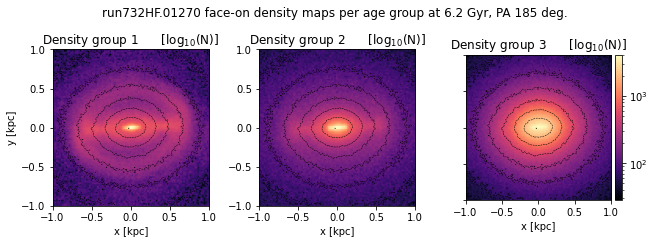

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01280.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 179.4765536288629 degrees
* Rotating the primary bar to PA 75 deg.
* Snap max age - 6.4Gyr.
** Total stars in snap -  9202470
*** Stars in age group 1  -  1631091
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.19
***** Radius - 0.03 kpc, ellipticity - 0.19
***** Radius - 0.04 kpc, ellipticity - 0.19
***** Radius - 0.05 kpc, ellipticity - 0.19
***** Radius - 0.06 kpc, ellipticity - 0.19
***** Radius - 0.07 kpc, ellipticity - 0.19
***** Radius - 0.08 kpc, ellipticity - 0.19
***** Radius - 0.09 kpc, ellipticity - 0.19
***** Radius - 0.1 kpc, ellipticity - 0.2
***** Radius - 0.11 kpc, ellipticity - 0.21
***** Radius - 0.12 kpc, ellipticity - 0.23
***** Radius - 0.13 kpc, ellipticity - 0.24
***** Radius - 0.14 kpc, ellipticity - 0.26
***** Radius - 0.15 kpc, ellipticity - 0.28
****

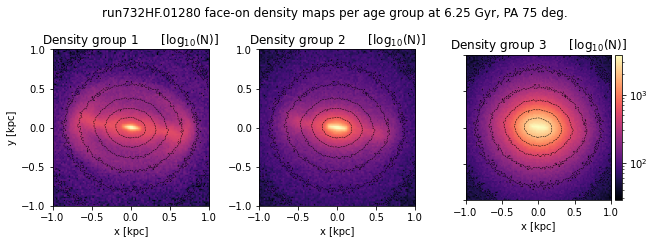

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01290.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 80.98668426330768 degrees
* Rotating the primary bar to PA 155 deg.
* Snap max age - 6.45Gyr.
** Total stars in snap -  9233744
*** Stars in age group 1  -  1634369
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.07
***** Radius - 0.03 kpc, ellipticity - 0.07
***** Radius - 0.04 kpc, ellipticity - 0.06
***** Radius - 0.05 kpc, ellipticity - 0.08
***** Radius - 0.06 kpc, ellipticity - 0.08
***** Radius - 0.07 kpc, ellipticity - 0.1
***** Radius - 0.08 kpc, ellipticity - 0.12
***** Radius - 0.09 kpc, ellipticity - 0.13
***** Radius - 0.1 kpc, ellipticity - 0.15
***** Radius - 0.11 kpc, ellipticity - 0.17
***** Radius - 0.12 kpc, ellipticity - 0.19
***** Radius - 0.13 kpc, ellipticity - 0.22
***** Radius - 0.14 kpc, ellipticity - 0.24
***** Radius - 0.15 kpc, ellipticity - 0.27
**

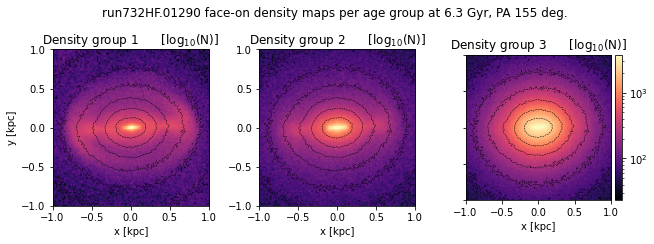

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01300.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -164.49311371554302 degrees
* Rotating the primary bar to PA 15 deg.
* Snap max age - 6.5Gyr.
** Total stars in snap -  9265767
*** Stars in age group 1  -  1637489
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - -0.04
***** Radius - 0.03 kpc, ellipticity - -0.06
***** Radius - 0.04 kpc, ellipticity - -0.05
***** Radius - 0.05 kpc, ellipticity - -0.05
***** Radius - 0.06 kpc, ellipticity - -0.03
***** Radius - 0.07 kpc, ellipticity - -0.01
***** Radius - 0.08 kpc, ellipticity - 0.0
***** Radius - 0.09 kpc, ellipticity - 0.02
***** Radius - 0.1 kpc, ellipticity - 0.04
***** Radius - 0.11 kpc, ellipticity - 0.07
***** Radius - 0.12 kpc, ellipticity - 0.09
***** Radius - 0.13 kpc, ellipticity - 0.12
***** Radius - 0.14 kpc, ellipticity - 0.14
***** Radius - 0.15 kpc, ellipticity - 0

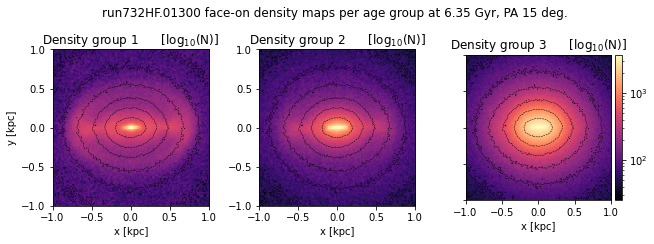

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01310.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 127.40061832790695 degrees
* Rotating the primary bar to PA 45 deg.
* Snap max age - 6.55Gyr.
** Total stars in snap -  9296457
*** Stars in age group 1  -  1641024
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.1
***** Radius - 0.03 kpc, ellipticity - 0.11
***** Radius - 0.04 kpc, ellipticity - 0.12
***** Radius - 0.05 kpc, ellipticity - 0.12
***** Radius - 0.06 kpc, ellipticity - 0.13
***** Radius - 0.07 kpc, ellipticity - 0.13
***** Radius - 0.08 kpc, ellipticity - 0.14
***** Radius - 0.09 kpc, ellipticity - 0.15
***** Radius - 0.1 kpc, ellipticity - 0.16
***** Radius - 0.11 kpc, ellipticity - 0.17
***** Radius - 0.12 kpc, ellipticity - 0.19
***** Radius - 0.13 kpc, ellipticity - 0.21
***** Radius - 0.14 kpc, ellipticity - 0.23
***** Radius - 0.15 kpc, ellipticity - 0.26
**

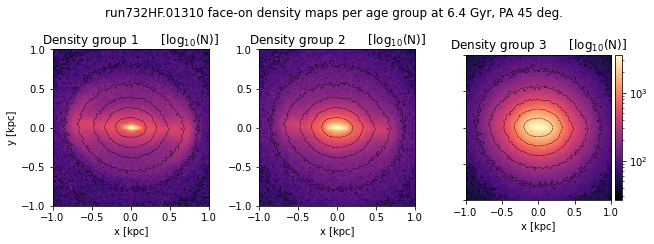

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01320.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 84.71445997281806 degrees
* Rotating the primary bar to PA 30 deg.
* Snap max age - 6.6Gyr.
** Total stars in snap -  9328025
*** Stars in age group 1  -  1645674
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.05
***** Radius - 0.03 kpc, ellipticity - 0.05
***** Radius - 0.04 kpc, ellipticity - 0.05
***** Radius - 0.05 kpc, ellipticity - 0.05
***** Radius - 0.06 kpc, ellipticity - 0.06
***** Radius - 0.07 kpc, ellipticity - 0.07
***** Radius - 0.08 kpc, ellipticity - 0.08
***** Radius - 0.09 kpc, ellipticity - 0.09
***** Radius - 0.1 kpc, ellipticity - 0.1
***** Radius - 0.11 kpc, ellipticity - 0.11
***** Radius - 0.12 kpc, ellipticity - 0.13
***** Radius - 0.13 kpc, ellipticity - 0.16
***** Radius - 0.14 kpc, ellipticity - 0.18
***** Radius - 0.15 kpc, ellipticity - 0.21
****

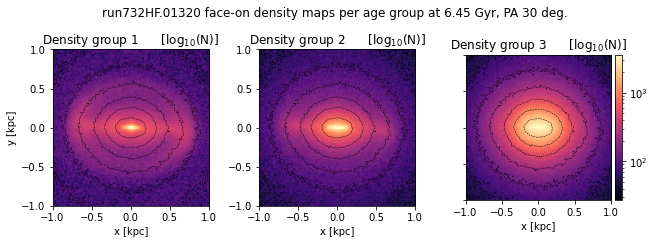

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01330.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -159.6927806294851 degrees
* Rotating the primary bar to PA 26 deg.
* Snap max age - 6.65Gyr.
** Total stars in snap -  9359476
*** Stars in age group 1  -  1648451
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.04
***** Radius - 0.03 kpc, ellipticity - 0.07
***** Radius - 0.04 kpc, ellipticity - 0.06
***** Radius - 0.05 kpc, ellipticity - 0.07
***** Radius - 0.06 kpc, ellipticity - 0.08
***** Radius - 0.07 kpc, ellipticity - 0.09
***** Radius - 0.08 kpc, ellipticity - 0.1
***** Radius - 0.09 kpc, ellipticity - 0.11
***** Radius - 0.1 kpc, ellipticity - 0.13
***** Radius - 0.11 kpc, ellipticity - 0.15
***** Radius - 0.12 kpc, ellipticity - 0.17
***** Radius - 0.13 kpc, ellipticity - 0.19
***** Radius - 0.14 kpc, ellipticity - 0.22
***** Radius - 0.15 kpc, ellipticity - 0.25
**

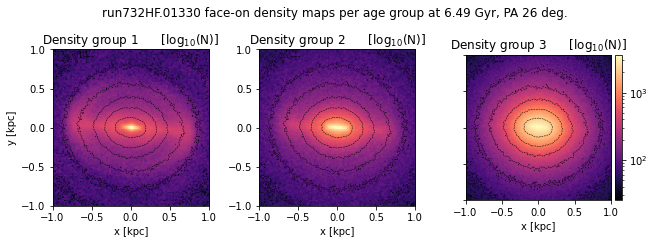

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01340.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 145.48701448075272 degrees
* Snap max age - 6.7Gyr.
** Total stars in snap -  9390966
*** Stars in age group 1  -  1653455
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.04
***** Radius - 0.03 kpc, ellipticity - 0.05
***** Radius - 0.04 kpc, ellipticity - 0.06
***** Radius - 0.05 kpc, ellipticity - 0.06
***** Radius - 0.06 kpc, ellipticity - 0.07
***** Radius - 0.07 kpc, ellipticity - 0.07
***** Radius - 0.08 kpc, ellipticity - 0.08
***** Radius - 0.09 kpc, ellipticity - 0.08
***** Radius - 0.1 kpc, ellipticity - 0.09
***** Radius - 0.11 kpc, ellipticity - 0.11
***** Radius - 0.12 kpc, ellipticity - 0.13
***** Radius - 0.13 kpc, ellipticity - 0.15
***** Radius - 0.14 kpc, ellipticity - 0.17
***** Radius - 0.15 kpc, ellipticity - 0.2
***** Radius - 0.16 kpc, ellipticity - 0.22


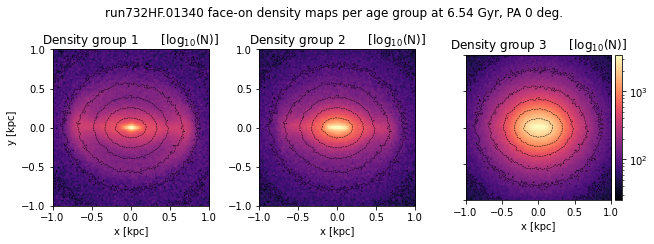

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01350.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -145.0096509512555 degrees
* Rotating the primary bar to PA 27 deg.
* Snap max age - 6.75Gyr.
** Total stars in snap -  9422484
*** Stars in age group 1  -  1657425
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.1
***** Radius - 0.03 kpc, ellipticity - 0.1
***** Radius - 0.04 kpc, ellipticity - 0.09
***** Radius - 0.05 kpc, ellipticity - 0.11
***** Radius - 0.06 kpc, ellipticity - 0.12
***** Radius - 0.07 kpc, ellipticity - 0.12
***** Radius - 0.08 kpc, ellipticity - 0.13
***** Radius - 0.09 kpc, ellipticity - 0.15
***** Radius - 0.1 kpc, ellipticity - 0.15
***** Radius - 0.11 kpc, ellipticity - 0.17
***** Radius - 0.12 kpc, ellipticity - 0.19
***** Radius - 0.13 kpc, ellipticity - 0.21
***** Radius - 0.14 kpc, ellipticity - 0.23
***** Radius - 0.15 kpc, ellipticity - 0.26
***

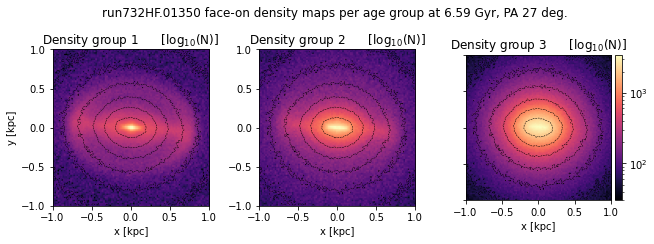

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01360.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -169.99262448001969 degrees
* Rotating the primary bar to PA 135 deg.
* Snap max age - 6.8Gyr.
** Total stars in snap -  9453550
*** Stars in age group 1  -  1660440
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - -0.03
***** Radius - 0.03 kpc, ellipticity - -0.01
***** Radius - 0.04 kpc, ellipticity - 0.01
***** Radius - 0.05 kpc, ellipticity - 0.01
***** Radius - 0.06 kpc, ellipticity - 0.03
***** Radius - 0.07 kpc, ellipticity - 0.04
***** Radius - 0.08 kpc, ellipticity - 0.05
***** Radius - 0.09 kpc, ellipticity - 0.06
***** Radius - 0.1 kpc, ellipticity - 0.07
***** Radius - 0.11 kpc, ellipticity - 0.09
***** Radius - 0.12 kpc, ellipticity - 0.11
***** Radius - 0.13 kpc, ellipticity - 0.14
***** Radius - 0.14 kpc, ellipticity - 0.17
***** Radius - 0.15 kpc, ellipticity - 0.1

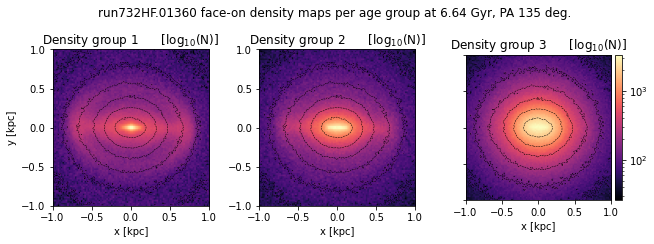

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01370.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -149.448003699958 degrees
* Rotating the primary bar to PA 10 deg.
* Snap max age - 6.85Gyr.
** Total stars in snap -  9484546
*** Stars in age group 1  -  1664028
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.03
***** Radius - 0.03 kpc, ellipticity - 0.07
***** Radius - 0.04 kpc, ellipticity - 0.06
***** Radius - 0.05 kpc, ellipticity - 0.06
***** Radius - 0.06 kpc, ellipticity - 0.05
***** Radius - 0.07 kpc, ellipticity - 0.06
***** Radius - 0.08 kpc, ellipticity - 0.06
***** Radius - 0.09 kpc, ellipticity - 0.07
***** Radius - 0.1 kpc, ellipticity - 0.08
***** Radius - 0.11 kpc, ellipticity - 0.1
***** Radius - 0.12 kpc, ellipticity - 0.12
***** Radius - 0.13 kpc, ellipticity - 0.14
***** Radius - 0.14 kpc, ellipticity - 0.16
***** Radius - 0.15 kpc, ellipticity - 0.19
***

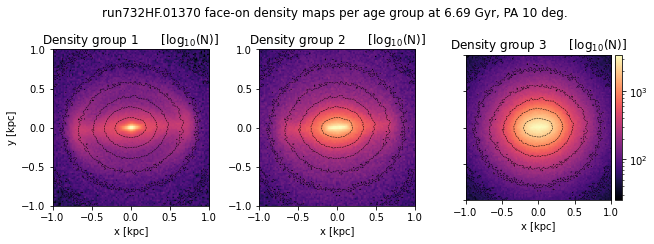

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01380.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -149.53226537413994 degrees
* Rotating the primary bar to PA 85 deg.
* Snap max age - 6.9Gyr.
** Total stars in snap -  9514870
*** Stars in age group 1  -  1665253
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.03
***** Radius - 0.03 kpc, ellipticity - 0.04
***** Radius - 0.04 kpc, ellipticity - 0.06
***** Radius - 0.05 kpc, ellipticity - 0.06
***** Radius - 0.06 kpc, ellipticity - 0.06
***** Radius - 0.07 kpc, ellipticity - 0.06
***** Radius - 0.08 kpc, ellipticity - 0.07
***** Radius - 0.09 kpc, ellipticity - 0.07
***** Radius - 0.1 kpc, ellipticity - 0.08
***** Radius - 0.11 kpc, ellipticity - 0.09
***** Radius - 0.12 kpc, ellipticity - 0.1
***** Radius - 0.13 kpc, ellipticity - 0.12
***** Radius - 0.14 kpc, ellipticity - 0.14
***** Radius - 0.15 kpc, ellipticity - 0.17
**

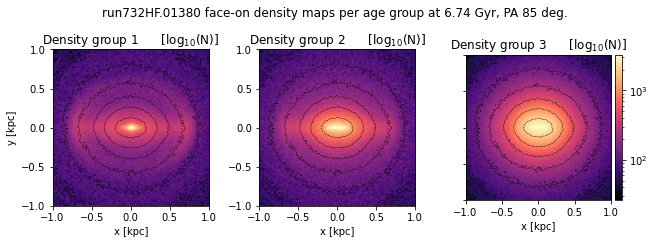

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01390.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 171.5173462072431 degrees
* Rotating the primary bar to PA 5 deg.
* Snap max age - 6.95Gyr.
** Total stars in snap -  9544868
*** Stars in age group 1  -  1668464
*** Age group - 1
***** Radius - 0.02 kpc, ellipticity - 0.07
***** Radius - 0.03 kpc, ellipticity - 0.1
***** Radius - 0.04 kpc, ellipticity - 0.08
***** Radius - 0.05 kpc, ellipticity - 0.09
***** Radius - 0.06 kpc, ellipticity - 0.09
***** Radius - 0.07 kpc, ellipticity - 0.1
***** Radius - 0.08 kpc, ellipticity - 0.11
***** Radius - 0.09 kpc, ellipticity - 0.12
***** Radius - 0.1 kpc, ellipticity - 0.13
***** Radius - 0.11 kpc, ellipticity - 0.15
***** Radius - 0.12 kpc, ellipticity - 0.17
***** Radius - 0.13 kpc, ellipticity - 0.19
***** Radius - 0.14 kpc, ellipticity - 0.22
***** Radius - 0.15 kpc, ellipticity - 0.25
*****

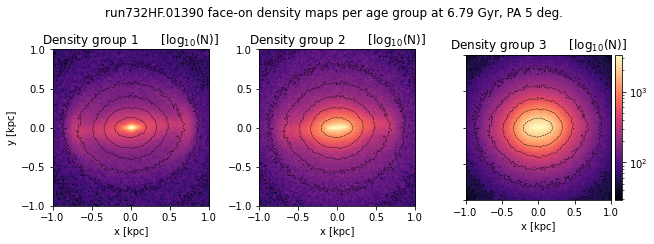

In [ ]:
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 100
cmap = 'magma'
plt_title = ' face-on density maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]',
                  'σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3

# Figure 8 - 10
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Appendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]
pa_lst = [45,80,90,170,90,120,95,185,75,155,15,45,30,26,0,27,135,10,85,5]

# Figure 8
#pa_lst = [0]
#snap_lst = ['run732HF.01380.gz']

# Figure 9
#pa_lst = [0,0]
#snap_lst = ['run732HF.01340.gz', 'run732HF.01360.gz']

# Figure 10
#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

# Figure 12 - discarded, no X-shape, 
# but could be used as a negative control
# SB model 708
#pa_lst = [90]
#incl_lst = [85,88,89,90,91,92,95]

#pa_lst = [-45,-60,-64,-90,-63,45,-80,-5,-85]
#pa_lst = [45,30,26,0,27,-45,10,85,5]
#snap_lst = ['run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
#            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
#            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

div_lst = [1/3]

per_radius = True

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        pa = pa_lst[j]
        if pa != 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
            
        for incl in incl_lst:
    
            stat2d_lst = []

            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
            '''
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(df_stat2d.T)
            '''
                        
            # Divide snapshot into 3 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr.')
            print('** Total stars in snap - ', len(s.star))
            
            # Number density statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            age_grp = 0
            for divlr in divlr_lst:
                age_grp += 1
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]
                print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
                
                # Number density statistics face-on for stellar population by age group
                dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(dfg_stat2d.T)
            
                s_xaxis = []
                s_yaxis = [0]*bins

                for e in dfg_stat2d:
                    s_xaxis.append(sum(e))
                    s_yaxis = s_yaxis + e
            
                r_lst = []
                unit = 2*xlim/bins

                for iter in range (0, int(bins/2)):
                    r = xlim - unit*iter
                    r_lst.append(r)
                #print(r_lst)

                for iter in range (0, int(bins/2)):
                    r = unit + unit*iter
                    r_lst.append(r)
                #print(r_lst)

                if per_radius:
                    print('*** Age group -', age_grp)
                
                    for bin in range (2, bins):
                        q_x = 0
                        q_y = 0

                        for iter in range (0, bin - 1):
                            q_y = q_y + s_yaxis[iter]*(r_lst[iter]**2)
                            q_x = q_x + s_xaxis[iter]*(r_lst[iter]**2)

                        e = 1- sqrt(q_y / q_x)

                        print('***** Radius -',round(unit*bin/2,2), 'kpc, ellipticity -',round(e,2))

                q_x = 0
                q_y = 0

                for iter in range (0, bins - 1):
                    q_y = q_y + s_yaxis[iter]*(r_lst[iter]**2)
                    q_x = q_x + s_xaxis[iter]*(r_lst[iter]**2)

                e = 1- sqrt(q_y / q_x)

                print('*** Age group', age_grp, 'ellipticity -',round(e,2))

            # Rotate to a given inclination
            #print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            #s.rotate_x(-incl) 
        
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            for i in range(x_panels):
                        image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                        xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                        ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                        axes[i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                        axes[i].title.set_text(splt_title_lst[i])

            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])

            #print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            #s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_density_by_age_3grp_' + str(xlim) + 'kpc_pa' + str(pa) + '.png')
            print('**** Done!')
            plt.show()
            
        j += 1

#### Face-on - bar development, model 708

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656056 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 174.59931084286313 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 88.64641316008235 degrees


IndexError: index 2 is out of bounds for axis 0 with size 2

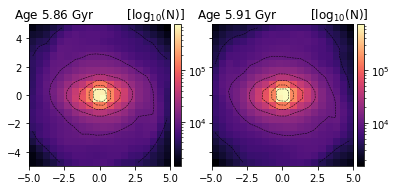

In [ ]:
# Figure 6
#
# Zoom in
# Primary bar
xlim, ylim = 5, 5 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on view of ' + str(xlim) + ' kpc area' + ' - log$_{10}$ density timeline.'

# Model 708
panels = 2

figsize_x = 3*panels
figsize_y = 3.5
# make the figure and sub plots
fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))

i = 0
for snap in snap_lst:

        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        s = pbload(base_dir + snap,param_fname,log=True)
      
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                statistic = 'count',
                                range = [[-xlim,xlim],[-ylim,ylim]],
                                bins = bins)
    
        image = axes[i].imshow(stat2d.T, 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
        xcent = (xedges[1:] + xedges[:-1]) / 2
        ycent = (yedges[1:] + yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
        splt_title = 'Age ' + str(age) + ' Gyr' + '         [log$_{10}$(N)]'
        axes[i].title.set_text(splt_title)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(image, cax=cax, orientation='vertical')
        #cbar.set_label(cbar_label_lst[i])
        if i > 0:
            axes[i].set_yticklabels([])
        i += 1

fig.tight_layout()
fig.suptitle(snap.replace(".gz","") + plt_title)
plt.setp(axes[:], xlabel = 'x [kpc]')
plt.setp(axes[0], ylabel = 'y [kpc]')
plt.savefig(image_dir + snap.replace(".gz","") + '_face_on_num_density_' + str(xlim) + 'kpc' + '.png')
print('* Done!')
plt.show()


#### Face-on bar for different age groups

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01310.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 127.40061832790686 degrees
* Snap max age - 6.55Gyr.
** Total stars in snap -  9296457
*** Stars in age group 1  -  1641024
*** Stars in age group 2  -  2447906
*** Stars in age group 3  -  5207184
**** Done!


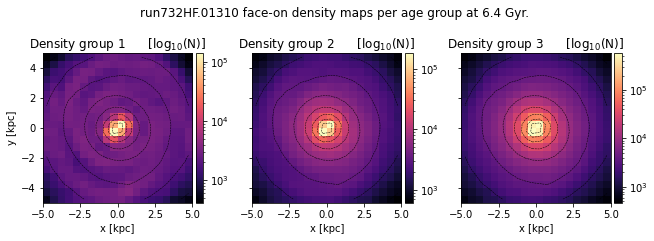

In [ ]:
# Zoom in
#xlim, ylim = 1, 1 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 3, 3 #kpc
xlim, ylim = 5, 5 #kpc
#xlim, ylim = 10, 10 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on density maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

#snap_lst = ['run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
#            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
#            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

snap_lst = ['run732HF.01310.gz']

div_lst = [1/3]

#j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        stat2d_lst = []
         
        # Make the figure and sub plots
        #fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        fig,axes = plt.subplots(1,x_panels,figsize=(figsize_x,figsize_y))
    
        '''
        # Number density statistics face-on for inner bar reference plot
        df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
        stat2d_lst.append(df_stat2d.T)
        '''
                        
        # Divide snapshot into 3 age groups
        max_age = round(max(s.star['age']),2)
        print('* Snap max age - ' + str(max_age) + 'Gyr.')
        print('** Total stars in snap - ', len(s.star))
            
        # Number density statistics per age group
        divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
        age_grp = 0
        for divlr in divlr_lst:
            age_grp += 1
            div_l = divlr[0]
            div_r = divlr[1]
            # Mask stars between age dividers div_l and div_r
            mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
            # print(len(mask))
            s_grp = s.star[mask]
            print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
            
            # Number density statistics face-on for stellar population by age group
            dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(dfg_stat2d.T)
    
        for i in range(x_panels):
            image = axes[i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
            xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
            ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
            axes[i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            axes[i].title.set_text(splt_title_lst[i])
                    
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])

        fig.tight_layout()
        fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr.')
        plt.setp(axes[:], xlabel = 'x [kpc]')
        plt.setp(axes[0], ylabel = 'y [kpc]')
        plt.savefig(image_dir + snap.replace(".gz","") + '_density_by_age_3grp_' + str(xlim) + 'kpc' + '.png')
        print('**** Done!')
        plt.show()
            
    #j += 1

### Velocity distribution

#### Edge-on velocity distribution map series

In [ ]:
# Figure 7
#
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
plt_title = ' edge-on velocity distribution maps'

# Figure 7
splt_title_lst = ['Density                          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]']

'''
# Figure 13
splt_title_lst = ['Density                          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]',
                  'h$_{3}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]',
                  'h$_{3}$    [km/s]',]
'''

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

# Density + mean velocity + sigma panels
# or
# mean velocity + sigma panels + h3
panels = 3

# Density + mean velocity + sigma panels + h3
# panels = 4

figsize_x = 3*panels
figsize_y = 3.5

incl = 90
pa_lst = [0]
#pa_lst = [0,30,60,90]

#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

# Figure 14
#pa_lst = [90]
# snap_lst = ['run761AV.02000.gz','run761BP.02000.gz','run761CK.02400.gz','run761CL.02400.gz']

j = 0

for pa in pa_lst:
    for snap in snap_lst:
        
        if j in iter_lst:
            stat2d_lst = []
        
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
    
            # Load snapshot data, center face-on, align primary bar using inertia tensor
            snap_name = snap.replace('.gz','')
            param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
            #print(param_fname[0])
            s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
            #s = pbload(base_dir + snap,param_fname,log=True)
    
            # Snapshot age
            age = round(s.properties['time'].in_units('Gyr'),2)
    
            if pa != 0:
                s.rotate_z(-pa)
                print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(df_stat2d.T)
        
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) # Rotate to certain inclination
    
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
            # Mean velicity statistics
            vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vm_stat2d.T)
    
            # Velocity dispersion statistics
            vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vd_stat2d.T)
    
            # Gauss-Hermite h3 moment
            h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h3_stat2d.T)
    
            '''
            # Gauss-Hermite h4 moment
            h4_stat2d,h4_xedges,h4_yedges,h4_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 4),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h4_stat2d.T)
            '''
    
            for i in range(panels):
                if i == 0:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                    xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                    ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                else:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                    ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
    
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])
        
            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.setp(axes[1], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('* Done!')
            plt.show()
            j += 1
        else:
            j += 1


#### Sigma maps by age for different PA and inclinations with density reference maps

from Jbook /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz /home/ubuntu/projects/S2B/models/run732HF/run732HF.param True True False
* Rotating the nuclear bar to PA 90 deg to end-on position.
* Snap max age - 6.0Gyr.
** Total stars in snap -  8926936
*** Stars in age group 1  -  1604410
*** Stars in age group 2  -  2385751
*** Stars in age group 3  -  4936358
* Tilting the galactic plane to 90 deg.
* Tilting the galactic plane back to -90 deg.
**** Done!


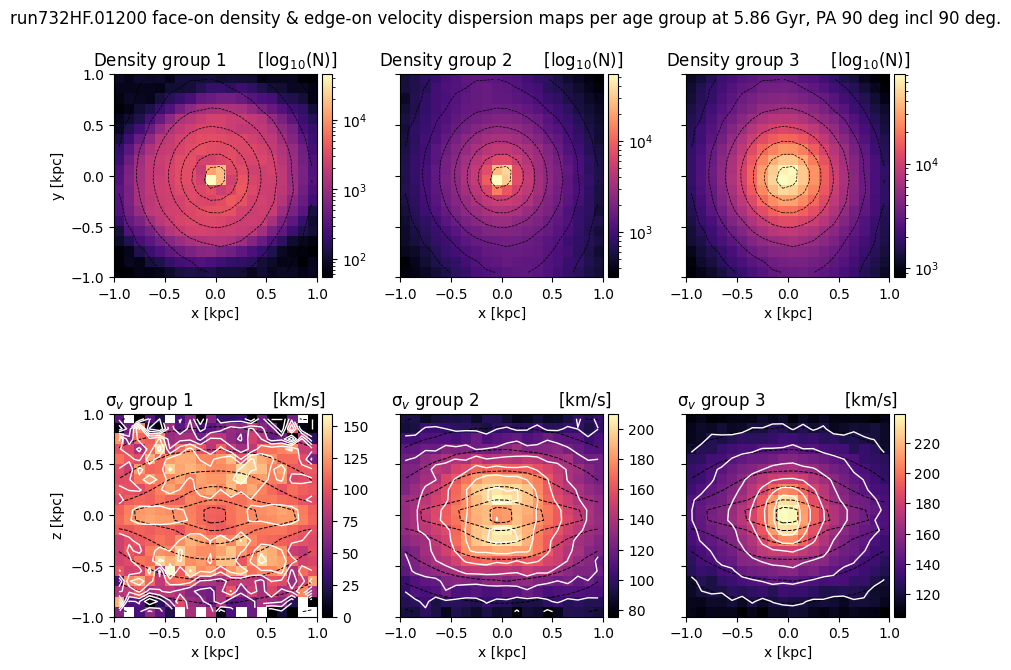

from Jbook /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz /home/ubuntu/projects/S2B/models/run732HF/run732HF.param True True False
* Rotating the nuclear bar to PA 90 deg to end-on position.
* Snap max age - 6.05Gyr.
** Total stars in snap -  8960917
*** Stars in age group 1  -  1604977
*** Stars in age group 2  -  2393218
*** Stars in age group 3  -  4962281
* Tilting the galactic plane to 90 deg.
* Tilting the galactic plane back to -90 deg.
**** Done!


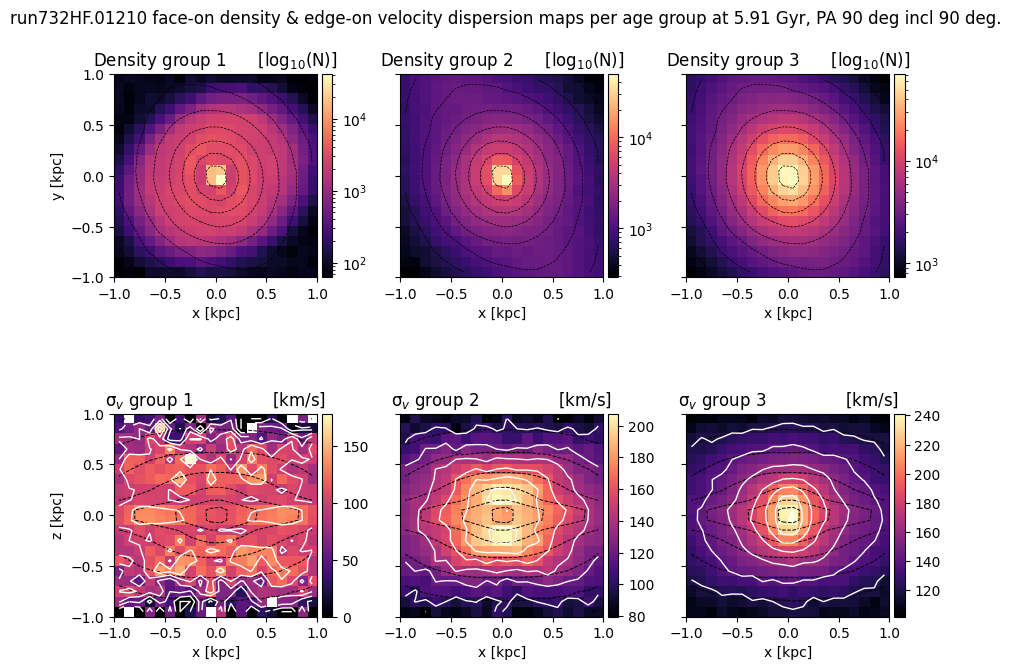

from Jbook /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz /home/ubuntu/projects/S2B/models/run732HF/run732HF.param True True False


: 

In [4]:
# Zoom in
xlim, ylim = 1, 1 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 3, 3 #kpc
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 10, 10 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on density & edge-on velocity dispersion maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]',
                  'σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

nuclear = True
log = True
polar_grid = False

step = 1
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3

# Figure 8 - 10
y_panels = 2

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# Position angle to rotate the nuclear bar end-on position.
pa = 90

#snap_lst = ['run732HF.01200.gz', 'run732HF.01210.gz', 'run732HF.01220.gz',
#            'run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
#            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
#            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

div_lst = [1/3]

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        #s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),nuclear, log)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        #pa = pa_lst[j]
        if pa != 0:
            s.rotate_z(-pa)
            print('* Rotating the nuclear bar to PA ' + str(pa) + ' deg to end-on position.')
            
        for incl in incl_lst:
    
            stat2d_lst = []
            
            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
            '''
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(df_stat2d.T)
            '''
                        
            # Divide snapshot into 3 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr.')
            print('** Total stars in snap - ', len(s.star))
            
            # Number density statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            age_grp = 0
            for divlr in divlr_lst:
                age_grp += 1
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]
                print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
                
                # Number density statistics face-on for stellar population by age group
                dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(dfg_stat2d.T)
            
            # Rotate to a given inclination
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
        
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            # Velocity statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            for divlr in divlr_lst:
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]

                '''
                # Mean velicity statistics
                vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
                stat2d_lst.append(vm_stat2d.T)
                '''
    
                if polar_grid:
                    # Velocity deviation statistics in cylindrical coordinates
                    R_plot = np.hypot(s_grp.star['x'], s_grp.star['z']) # Hypotenuse of right angle triangle with x,z
                    phis = np.arctan2(s_grp.star['z'], s_grp.star['x'])
                    vd_stat2d, edges, binid = st.binned_statistic(R_plot, s_grp.star['vz'],
                                                                                 statistic = 'std',
                                                                                 bins = bins)
                else:
                    # Velocity deviation statistics in Cartesian coordinates
                    vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'std',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)

                stat2d_lst.append(vd_stat2d.T)
    
                '''
                # Gauss-Hermite h3 moment
                h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
                stat2d_lst.append(h3_stat2d.T)
                '''
            for k in range(y_panels):
                for i in range(x_panels):
                    if k == 0:
                        image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                        xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                        ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                        axes[k,i].title.set_text(splt_title_lst[3*k+i])
                    else:
                        if polar_grid:
                            plt.clf()
                            fig = plt.figure(figsize=[5,5])
                            ax = fig.add_axes([0.15,0.15,0.8,0.8])
                            thetas_radians, radii, z = make_r_theta_vals()
                            tr,rr = np.meshgrid(thetas_radians,radii)
                            x_vals = rr * np.cos(tr)
                            y_vals = rr * np.sin(tr)
                            ax.pcolormesh(x_vals,y_vals,z,edgecolors='face')
                            #ec='face' to avoid annoying gridding in pdf
                            plt.savefig('carte_polar.png')
                        else:
                            image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                                origin = 'lower',
                                extent = [-xlim, xlim, -ylim, ylim ],
                                cmap = cmap)
                            xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                            ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                            axes[k,i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                            xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                            ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                            axes[k,i].contour(xcent, ycent, stat2d_lst[3*k+i], linewidths = 1, linestyles = 'solid', colors = 'w')
                            axes[k,i].title.set_text(splt_title_lst[3*k+i])
                    
                    divider = make_axes_locatable(axes[k,i])
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                    #cbar.set_label(cbar_label_lst[i])
                    if i > 0:
                        axes[k,i].set_yticklabels([])

            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:,:], xlabel = 'x [kpc]')
            plt.setp(axes[0,0], ylabel = 'y [kpc]')
            plt.setp(axes[1,0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_by_age_3grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_cyl' + '.png')
            print('**** Done!')
            plt.show()
            
        j += 1

#### Sigma amplitude calculation

Data from:  run732HF.01360.gz
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01360.gz ...
* Centering the data...
* Short Bar, using 1 kpc
* Realigning bar using |z| < 0.25 
* Bar realigned by 143.23408430719695 degrees
Data from  run732HF.01360.gz
* Rotating the nuclear bar to PA 90 deg to end-on position.
* Tilting the galactic plane to 90 deg.
* Snap max age - 6.8Gyr.
** Total stars in snap -  9453550
*** Stars in age group 1  -  1660440
Size of R array 1660440
Size of phis array 1660440
Bin width:  0.05  kpc -> number of bins: 251
Size of sFp array 1660440
Size of cFp array 1660440
Size of sFp_sum array 251
Size of cFp_sum array 251
Size of R_mean array 251
Size of sigma_sum array 251


/tmp/ipykernel_24170/1919580874.py:142: RuntimeWarning: invalid value encountered in divide
  aF_plot = np.hypot(sigma_sum*sFp_sum, sigma_sum*cFp_sum)/(sigma_sum*bins)


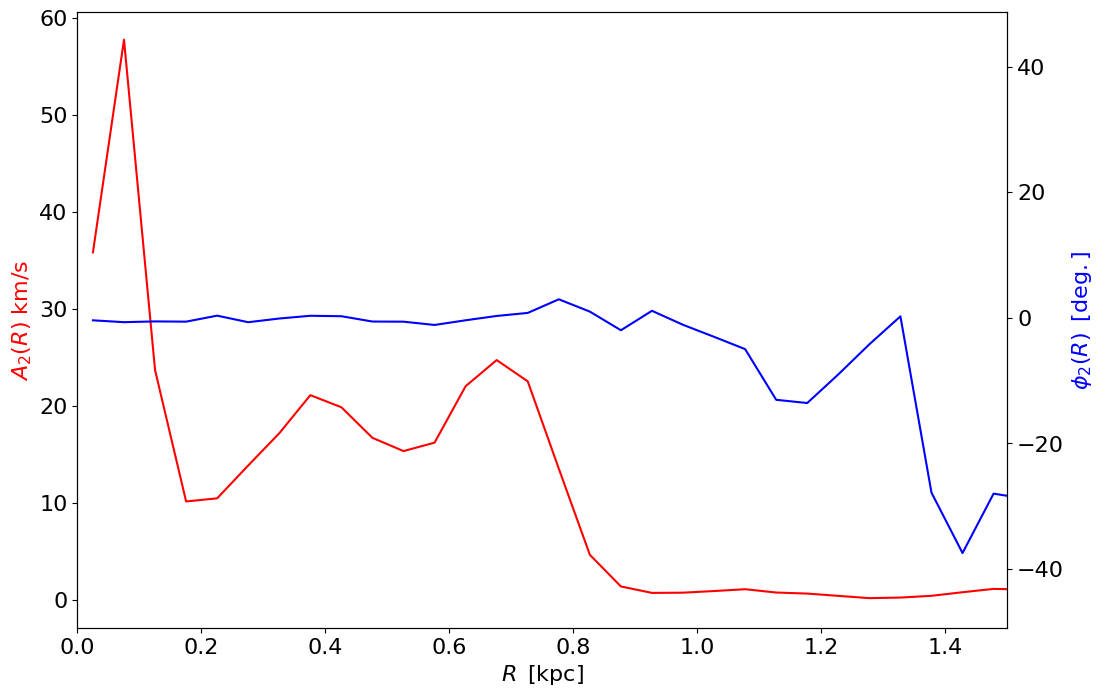

*** Stars in age group 2  -  2463866
Size of R array 2463866
Size of phis array 2463866
Bin width:  0.05  kpc -> number of bins: 316
Size of sFp array 2463866
Size of cFp array 2463866
Size of sFp_sum array 316
Size of cFp_sum array 316
Size of R_mean array 316
Size of sigma_sum array 316


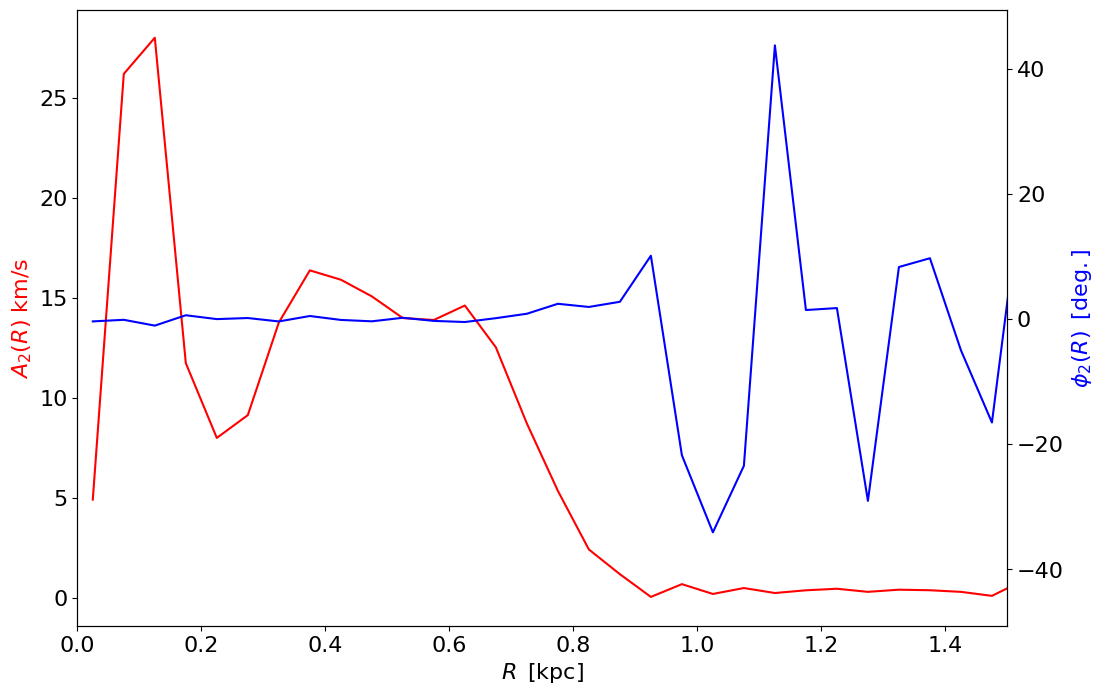

*** Stars in age group 3  -  5328858
Size of R array 5328858
Size of phis array 5328858
Bin width:  0.05  kpc -> number of bins: 634
Size of sFp array 5328858
Size of cFp array 5328858
Size of sFp_sum array 634
Size of cFp_sum array 634
Size of R_mean array 634
Size of sigma_sum array 634


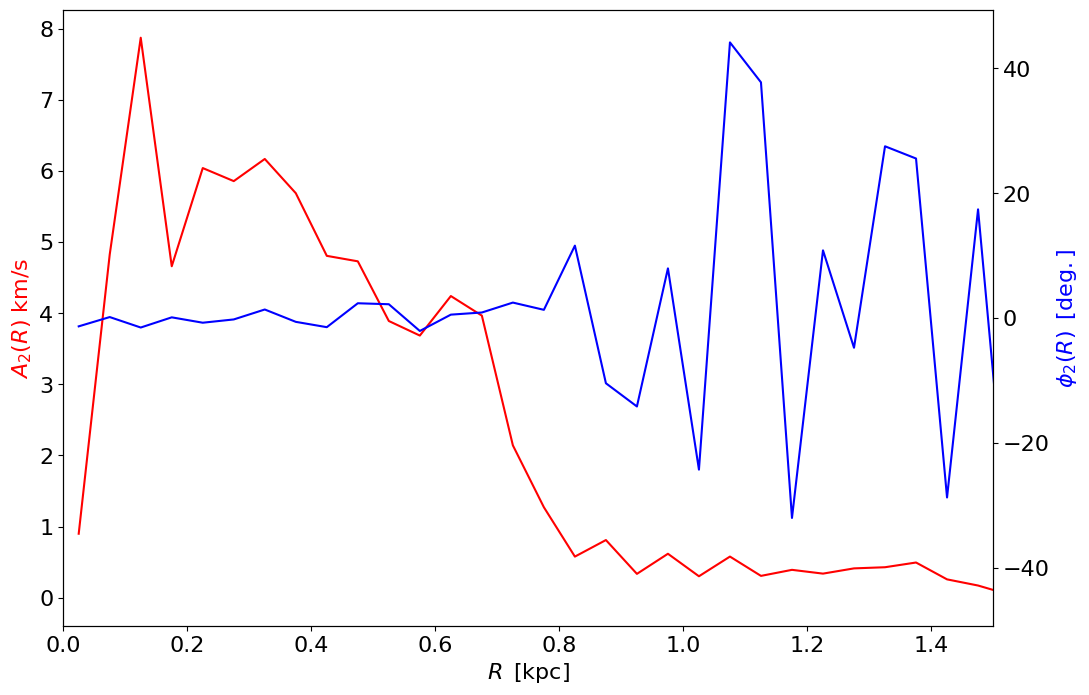

In [6]:
"""
Calculates and stores in an npy file the sigma radial extent by radius
using a4 and phi4
"""

import os, numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

from scipy.signal import find_peaks

plotting = True
nuclear = True
log = True

# Models
#model = "761"
model = "732HF"

if model == "761":
    bin_width = 0.3 #kpc
    xlim,ylim = 10,10 #kpc
    fname = "run761AV.02000.gz"
    param_fname = "run761AV.02000.param"
elif model == "732HF":
    bin_width = 0.05 #kpc
    xlim,ylim = 1,1 #kpc
    fname = "run732HF.01360.gz"
    param_fname = "run732HF.param"
    
print('Data from: ',fname)

master_folder = base_dir
os.chdir(master_folder)

output_folder = image_dir

# Load snapshot data, center face-on, align primary bar using inertia tensor
s = pbload(base_dir + str(fname),base_dir + str(param_fname[0]),nuclear, log)
print('Data from ', fname)

# Position angle to rotate the nuclear bar to the end-on position.
pa = 90
s.rotate_z(-pa)
print('* Rotating the nuclear bar to PA ' + str(pa) + ' deg to end-on position.')

# Rotate to the edge-on inclination
incl = 90
print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
s.rotate_x(-incl) 

stat2d_lst = []
            
# Divide snapshot into 3 age groups
max_age = round(max(s.star['age']),2)
print('* Snap max age - ' + str(max_age) + 'Gyr.')
print('** Total stars in snap - ', len(s.star))
            
# Sigma statistics and amplitude per age group
div = 1/3 # Group divider by age, youngest 1/3, intermidiate 1/3 and oldest 1/3

divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
age_grp = 0
for divlr in divlr_lst:
    age_grp += 1
    div_l = divlr[0]
    div_r = divlr[1]
    # Mask stars between age dividers div_l and div_r
    mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
    s_grp = s.star[mask]
    print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))

    #Extract phase space data for the model for stars in the group
    #z, x, = s_grp['z'], s_grp['x']
    z_, x_, y_, vz_, m_ = s_grp['z'], s_grp['x'], s_grp['y'], s_grp['vz'], s_grp['mass']

    #Calculate the radius of each particle and its cylindrical angle phi
    #R_plot = np.hypot(x, z) # Hypotenuse of right angle triangle with x,z
    #phis = np.arctan2(z, x)

    #Calculate the radius of each particle and its cylindrical angle phi
    R_plot = np.hypot(x_, z_) # Hypotenuse of right angle triangle with x,z
    phis = np.arctan2(z_, x_)

    # Debug output
    print("Size of R array", len(R_plot))
    print("Size of phis array", len(phis))

    # Calculate bins from a pre-defined bin width in kpc
    bins = int(R_plot.max()/bin_width)
    print("Bin width: ", bin_width, " kpc -> number of bins:", bins)

    # Velocity deviation (sigma) statistics
    #vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
    #                statistic = 'std',
    #                range = [[-xlim,xlim],[-ylim,ylim]],
    #                bins = bins)
    #
    #stat2d_lst.append(vd_stat2d.T) # We save per gorup sigma statistics here for multi-panel plotting in teh future

    # Plot the amplitude diagram first
    xlab = r'$R \rm \enspace [kpc]$'
    ylab = r'$A_2(R)$ km/s'
    y2lab = r'$\phi_2(R) \enspace \rm [deg.]$'

    Fm = 4 # Fourier component 4
    sFp = np.sin(Fm*phis) # for each mass particle = star
    cFp = np.cos(Fm*phis) # for each mass particle = star

    # Debug output
    print("Size of sFp array", len(sFp))
    print("Size of cFp array", len(cFp))

    # For each radial (xz) bin calculate the sigma (vz)
    vd_stat, edges, binid = stats.binned_statistic(R_plot, vz_, statistic = 'std', bins = bins)
    stat2d_lst.append(vd_stat.T) # We save per group sigma statistics here for multi-panel plotting in teh future

    # For each angular bin calculate the sigme amp and phase angle
    sFp_binned = stats.binned_statistic(R_plot, sFp, 'sum', bins=bins)
    cFp_binned = stats.binned_statistic(R_plot, cFp, 'sum', bins=bins)
    R_binned = stats.binned_statistic(R_plot, R_plot, 'mean', bins=bins)
    #sFp_binned = stats.binned_statistic(R_plot, m_ * sFp, 'sum', bins=bins)
    #cFp_binned = stats.binned_statistic(R_plot, m_ * cFp, 'sum', bins=bins)
    #mass_binned = stats.binned_statistic(R_plot, m_, 'sum', bins=bins)
    
    # extracting NP arrays from statistical data
    sFp_sum = sFp_binned.statistic.T
    cFp_sum = cFp_binned.statistic.T
    R_mean = R_binned.statistic.T
    #mass = mass_binned.statistic.T
    sigma_sum = vd_stat.T

    # Debug output
    print("Size of sFp_sum array", len(sFp_sum))
    print("Size of cFp_sum array", len(cFp_sum))
    print("Size of R_mean array", len(R_mean))
    print("Size of sigma_sum array", len(sigma_sum))
    
    # Stuart's discussion with Chiara (Nov 2020) - we need a factor 1/m (m is Fourier component) for the phase angle of the sigma.
    phiF_plot = (1/Fm) * np.degrees(np.arctan2(sFp_sum, cFp_sum))
    aF_plot = np.hypot(sigma_sum*sFp_sum, sigma_sum*cFp_sum)/(sigma_sum*bins)
    #a4_plot = np.hypot(sigma_sum*sFp_sum, sigma_sum*cFp_sum)/mass

    # Find midpoint of the bins
    radial_bins = sFp_binned.bin_edges[:-1] + np.diff(sFp_binned.bin_edges)/2

    # We do not use the following analysis for bars from Stuart code for sigma right now.
    """
    # We wish to locate where, after the initial settling, phi4 changes
    # from constant by more than 10 degrees
    # Set initial settling to be R = 1kpc and extract the first time the
    # absolute value goes above 10 degrees - this is the extent of the bar
    bar_ends_phi2_criterion = 10
    bar_ends_phi2 = phi2_plot[(radial_bins > 1) & (abs(phi2_plot) >= 
                           bar_ends_phi2_criterion)][0]
    bar_ends_R_phi2 = radial_bins[(radial_bins > 1) & (abs(phi2_plot) >= 
                          bar_ends_phi2_criterion)][0]

    # A low estimate for the bar would be half the a2 peak
    # The a2 peak is the first peak in the plot
    # Then find the half peak and its location
    a2_peaks, _ = find_peaks(a2_plot) 
    a2_max = a2_plot[a2_peaks[0]]

    a2_max_R = radial_bins[a2_peaks[0]]
    bar_ends_a2_criterion = 2

    # If this criteria is met then we do not have a bar
    if len(radial_bins[(radial_bins > a2_max_R) & 
        (a2_plot <= a2_max/bar_ends_a2_criterion)]) == 0:
        bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
    # If the bar amplitude a2_max falls below 0.2 then consider the bar unformed
    # and set the radii to be nan
    elif a2_max < 0.2:
        bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
    else:
        bar_ends_R_a2 = radial_bins[(radial_bins > a2_max_R) & 
                            (a2_plot <= a2_max/bar_ends_a2_criterion)][0]
    """

    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    ax = axes
    ax2 = ax.twinx()
    fs = 16

    ax.plot(radial_bins, aF_plot, c='r', label='r$A_2(R)$ km/s')
    ax2.plot(radial_bins, phiF_plot, c='b', label='r$\phi_2(R)$')
    ax.tick_params(axis='both', which='both', labelsize=fs)
    ax2.tick_params(axis='both', which='both', labelsize=fs)
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel(ylab, fontsize=fs, c='r')
    ax2.set_ylabel(y2lab, fontsize=fs, c='b')
    # We do not plot the analysis conditions for bars from Stuart code for sigma right now.
    #ax.axvline(bar_ends_R_a4, c='r', ls='--')
    #ax.axvline(bar_ends_R_phi4, c='b', ls='--')
    ax.set_xlim(0., 1.5)
    #ax.set_ylim(-3., 3.)

    plt.show()

# We do not print the analysis conditions for bars from Stuart code for sigma right now.
#print('For model {0}, the amp bar ends at R = {1} koc'.format(model, round(bar_ends_R_phi2, 2) ))
#print('For model {0}, the phase bar ends at R = {1} kpc'.format(model, round(bar_ends_R_a2, 2) ))

#### Sigma amplitude profiles - edge-on disk. end-on bar

In [ ]:
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on density & edge-on velocity dispersion maps per age group'
splt_title_lst = ['Density group 1      [log$_{10}$(N)]',
                  'Density group 2      [log$_{10}$(N)]',
                  'Density group 3      [log$_{10}$(N)]',
                  'σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'Log$_{10}$(N)',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

nuclear = True
log = True

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3
y_panels = 2

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

pa_lst = [90,90,90,90,90,90,90,90,90]

# Position angle to rotate the nuclear bar end-on position.
pa = 90

snap_lst = ['run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

div_lst = [1/3]

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),nuclear, log)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        if pa != 0:
            s.rotate_z(-pa)
            print('* Rotating the nuclear bar to PA ' + str(pa) + ' deg to end-on position.')
            
        for incl in incl_lst:
    
            stat2d_lst = []
            
            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
            '''
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
            stat2d_lst.append(df_stat2d.T)
            '''
                        
            # Divide snapshot into 3 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr.')
            print('** Total stars in snap - ', len(s.star))
            
            # Number density statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            age_grp = 0
            for divlr in divlr_lst:
                age_grp += 1
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]
                print('*** Stars in age group', age_grp, ' - ', len(s_grp.star['age']))
                
                # Number density statistics face-on for stellar population by age group
                dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(dfg_stat2d.T)
            
            # Rotate to a given inclination
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
        
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            # Velocity statistics per age group
            divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
            for divlr in divlr_lst:
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask stars between age dividers div_l and div_r
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]

                '''
                # Mean velicity statistics
                vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
                stat2d_lst.append(vm_stat2d.T)
                '''
    
                # Velocity deviation statistics
                vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'std',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(vd_stat2d.T)
    
                '''
                # Gauss-Hermite h3 moment
                h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
                stat2d_lst.append(h3_stat2d.T)
                '''
            for k in range(y_panels):
                for i in range(x_panels):
                    if k == 0:
                        image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                        xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                        ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                        axes[k,i].title.set_text(splt_title_lst[3*k+i])
                    else:
                        image = axes[k,i].imshow(stat2d_lst[3*k+i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                        xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                        ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                        xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                        ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                        axes[k,i].contour(xcent, ycent, stat2d_lst[3*k+i], linewidths = 1, linestyles = 'solid', colors = 'w')
                        axes[k,i].title.set_text(splt_title_lst[3*k+i])
                    
                    divider = make_axes_locatable(axes[k,i])
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                    #cbar.set_label(cbar_label_lst[i])
                    if i > 0:
                        axes[k,i].set_yticklabels([])

            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:,:], xlabel = 'x [kpc]')
            plt.setp(axes[0,0], ylabel = 'y [kpc]')
            plt.setp(axes[1,0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_by_age_3grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('**** Done!')
            plt.show()
            
        j += 1

#### Sigma maps by age for different PA and inclinations NO density reference maps

In [ ]:
# Zoom in
# model 732
xlim, ylim = 1, 1 #kpc
#
# model 708
#xlim, ylim = 5, 5 #kpc

bins = 20
cmap = 'magma'
plt_title = ' - velocity dispersion maps per age group'
splt_title_lst = ['σ$_{v}$ group 1               [km/s]',
                  'σ$_{v}$ group 2               [km/s]',
                  'σ$_{v}$ group 3               [km/s]']
cbar_label_lst = ['σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]',
                  'σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 3

# Figure 11
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Appendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

# Figure 11
# S2B model 732HF
incl_lst = [88,89,89.5,90,90.5,91,92]
pa_lst = [45]
snap_lst = ['run732HF.01360.gz']

# Figure 12 new
# S2B model 732HF
#incl_lst = [90]
#pa_lst = [40,41,42,43,44,45,46,47,48,49,50]
#pa_lst = [30,35,40,45,50,55,60]
#snap_lst = ['run732HF.01360.gz']

# Figure 12+
# SB model 708
#pa_lst = [0]
#incl_lst = [85,88,89,90,91,92,95]

div_lst = [1/3]

j = 0
for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        #pa = pa_lst[j]
            
        for incl in incl_lst:
            
            for pa in pa_lst:
                if pa != 0:
                    s.rotate_z(-pa)
                    print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
    
                stat2d_lst = []
            
                # Rotate to a given inclination
                print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
                s.rotate_x(-incl)
            
                # Make the figure and sub plots
                fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
        
                '''
                # Number density statistics face-on for inner bar reference plot
                df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                   statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(df_stat2d.T)
                '''
                        
                # Divide snapshot into 3 age groups
                max_age = round(max(s.star['age']),2)
                print('* Snap max age - ' + str(max_age) + 'Gyr.')
                print('** Total stars in snap - ', len(s.star))
                
                # Number density statistics for velocity maps density contours
                de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
                # Velocity statistics per age group
                divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
                for divlr in divlr_lst:
                    div_l = divlr[0]
                    div_r = divlr[1]
                    # Mask stars between age dividers div_l and div_r
                    mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                    # print(len(mask))
                    s_grp = s.star[mask]

                    '''
                    # Mean velicity statistics
                    vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'mean',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                    stat2d_lst.append(vm_stat2d.T)
                    '''

                    # Velocity deviation statistics
                    vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = 'std',
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(vd_stat2d.T)

                    '''
                    # Gauss-Hermite h3 moment
                    h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(h3_stat2d.T)
                    '''
                
                for i in range(x_panels):
                    gf_result = gf(stat2d_lst[i],sigma=0.25)
                    image = axes[i].imshow(gf_result, 
                                origin = 'lower',
                                extent = [-xlim, xlim, -ylim, ylim ],
                                cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                    ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, gf_result, linewidths = 1, linestyles = 'solid', colors = 'w')
                    axes[i].title.set_text(splt_title_lst[i])
                        
                    divider = make_axes_locatable(axes[i])
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                    #cbar.set_label(cbar_label_lst[i])
                    if i > 0:
                        axes[i].set_yticklabels([])

                print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
                s.rotate_x(incl) # Rotate back to original position

                if pa != 0:
                    s.rotate_z(pa)
                    print('* Rotating the primary bar back to original PA ' + str(pa) + ' deg.')

                fig.tight_layout()
                fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
                plt.setp(axes[:], xlabel = 'x [kpc]')
                plt.setp(axes[0], ylabel = 'z [kpc]')
                plt.savefig(image_dir + snap.replace(".gz","") + '_no_dens_LOSVD_by_age_3grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
                print('**** Done!')
                plt.show()

        j = j + 1


#### Sigma maps for ONE star age group for different PA and inclinations NO density reference maps

In [ ]:
from scipy.ndimage import gaussian_filter as gf
hist=plt.hist2d(sim['HR'].s['x'],sim['HR'].s['y'],bins=np.linspace(-30,30,100),norm=LN())
plt.contour(gf(hist[0],sigma=1),levels=np.logspace(1,5,50))

# Also try a background subtraction

In [ ]:
# Zoom in
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
plt_title = ' - velocity dispersion maps age group 1'
splt_title_lst = ['σ$_{v}$ group 1  ','  [km/s]']
cbar_label_lst = ['σ$_{v}$ [km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

x_panels = 4

# Figure 11
y_panels = 1

figsize_x = 3*x_panels      # inches
figsize_y = 3.5*y_panels    # inches

incl_lst = [90]

# For Apendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

# Figure 11
# S2B model 732HF
#incl_lst = [85,88,89,90,91,92,95]
#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

# Figure 12 new
# S2B model 732HF
incl_lst = [90]
#pa_lst = [40,41,42,43,44,45,46,47,48,49,50]
pa_base = 45
pa_delta = -30
pa_lst = [pa_base,pa_base + pa_delta,pa_base + 2*pa_delta,pa_base + 3*pa_delta]
snap_lst = ['run732HF.01360.gz']

div_lst = [1/3]

for div in div_lst:
    for snap in snap_lst:
              
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,base_dir + param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        # Max age and number of stars in snapshot
        max_age = round(max(s.star['age']),2)
        print('* Snap max age - ' + str(max_age) + 'Gyr.')
        print('** Total stars in snap - ', len(s.star))
       
        for incl in incl_lst:
                      
            # Make the figure and sub plots
            fig,axes = plt.subplots(y_panels,x_panels,figsize=(figsize_x,figsize_y))
            
            i = 0
            
            for pa in pa_lst:
                if pa != 0:
                    print('* Rotating the primary bar to PA ' + str(pa) + ' deg.')
                    s.rotate_z(-pa)
    
                stat2d_lst = []
            
                # Rotate to a given inclination
                print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
                s.rotate_x(-incl)
            
                # Number density statistics for velocity maps density contours
                de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
                # Velocity statistics per age group 1
                divlr_lst = [[0,div]]
                for divlr in divlr_lst:
                    div_l = divlr[0]
                    div_r = divlr[1]
                    # Mask stars between age dividers div_l and div_r
                    mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                    # print(len(mask))
                    s_grp = s.star[mask]

                    '''
                    # Mean velicity statistics
                    vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'mean',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                    stat2d_lst.append(vm_stat2d.T)
                    '''

                    # Velocity deviation statistics
                    vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = 'std',
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(vd_stat2d.T)

                    '''
                    # Gauss-Hermite h3 moment
                    h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                        statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                        range = [[-xlim,xlim],[-ylim,ylim]],
                                        bins = bins)
                    stat2d_lst.append(h3_stat2d.T)
                    '''
                
                gf_result = gf(stat2d_lst[0],sigma=0.25)
                image = axes[i].imshow(gf_result, 
                                origin = 'lower',
                                extent = [-xlim, xlim, -ylim, ylim ],
                                cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, gf_result, linewidths = 1, linestyles = 'solid', colors = 'w')
                #axes[i].title.set_text(splt_title_lst[0])
                
                PA_nb = 90 + i*pa_delta
                print('Panel:', i, '\tPA: ', pa, '\tPA_nb:', PA_nb)
                
                axes[i].title.set_text(splt_title_lst[0] + 'PA$_{NB}$ ' + str(PA_nb) + ' deg ' + splt_title_lst[1])
                        
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])

                print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
                s.rotate_x(incl) # Rotate back to original position

                if pa != 0:
                    s.rotate_z(pa)
                    print('* Rotating the primary bar back to original PA ' + str(-pa) + ' deg.')

                i+=1
                
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr,' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_no_dens_LOSVD_by_age_1grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('**** Done!')
            plt.show()


#### Edge-on velocity components, NO density

In [ ]:
# Figure 14
#
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
xlim, ylim = 1, 1 #kpc
bins = 20
cmap = 'magma'
#plt_title = '732HF face-on number density & edge-on velocity and h3 maps per age group'
plt_title = ' mean velocity, velocity dispersion and h3 maps for age group 1'
splt_title_lst = ['v$_{mean}$ group 1     [km/s]',
                  'σ$_{v}$ group 1        [km/s]',
                  'h$_{3}$ group 1        [km/s]']
cbar_label_lst = ['[km/s]',
                  '[km/s]',
                  '[km/s]']

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

panels = 3
figsize_x = 3*panels
figsize_y = 3.5

incl_lst = [90]
#incl_lst = [85,88,89,90,91,92,95]

# pa_lst = [0]
# for Appendix
#pa_lst = [-45,-10,0,80,0,30,5,95,-15,65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]

#pa_lst = [-5,-85]
#snap_lst = ['run732HF.01380.gz', 'run732HF.01390.gz']

# Figure 14
#pa_lst = [45]
#snap_lst = ['run732HF.01360.gz']

pa_lst = [65,-75,-45,-60,-64,-90,-63,45,-80,-5,-85]
snap_lst = ['run732HF.01290.gz','run732HF.01300.gz',
            'run732HF.01310.gz','run732HF.01320.gz','run732HF.01330.gz',
            'run732HF.01340.gz','run732HF.01350.gz','run732HF.01360.gz',
            'run732HF.01370.gz', 'run732HF.01380.gz','run732HF.01390.gz']

#pa_lst = [90]
#snap_lst = ['run708mainDiffCR.01200.gz']

div_lst = [1/3]

# for pa in pa_lst:
for div in div_lst:
    j = 0
    for snap in snap_lst:
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        snap_name = snap.replace('.gz','')
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
        #s = pbload(base_dir + snap,param_fname,log=True)
        
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        pa = pa_lst[j]
        if pa != 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
        for incl in incl_lst:
    
            stat2d_lst = []
            
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
        
            # Divide snapshot into 2 age groups
            max_age = round(max(s.star['age']),2)
            print('* Snap max age - ' + str(max_age) + 'Gyr')
            print('** Total stars in snap - ', len(s.star))
                       
            # Rotate to a given inclination
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
        
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                    statistic = 'count',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                
            # Velocity statistics per age group
            divlr_lst = [[0,div]]
            for divlr in divlr_lst:
                div_l = divlr[0]
                div_r = divlr[1]
                # Mask group 1 stars
                mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
                # print(len(mask))
                s_grp = s.star[mask]

                # Mean velicity statistics
                vm_stat2d,vm_xedges,vm_yedges,vm_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
                stat2d_lst.append(vm_stat2d.T)
    
                # Velocity deviation statistics
                vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                    statistic = 'std',
                                    range = [[-xlim,xlim],[-ylim,ylim]],
                                    bins = bins)
                stat2d_lst.append(vd_stat2d.T)
    
                # Gauss-Hermite h3 moment
                h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
                stat2d_lst.append(h3_stat2d.T)

            for i in range(panels):
                image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
            
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])
        
            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Rotate back to original position
        
            fig.tight_layout()
            fig.suptitle(snap.replace(".gz","") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg' + ' incl ' + str(incl) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_h3_by_age_1grp_' + str(xlim) + 'kpc_pa' + str(pa) + '_incl' + str(incl) + '.png')
            print('* Done!')
            plt.show()
            
        j += 1
            

#### Edge-on velocity distribution map series

In [ ]:
# Figure 13
#
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 1, 1 #kpc
#xylim_lst = [1,2,5] #kpc
xylim_lst = [15] #kpc
bins = 20
cmap = 'magma'
plt_title = ' edge-on velocity distribution maps'
splt_title_lst = ['Number density          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]',
                  'h$_{3}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]',
                  'h$_{3}$    [km/s]',]

panels = 4
figsize_x = 3*panels
figsize_y = 3.5

incl = 90
pa_lst = [90]

for snap in snap_lst:
    for xylim in xylim_lst:
        # Define zoom-in area
        xlim = xylim
        ylim = xylim
        for pa in pa_lst:
    
            stat2d_lst = []
        
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
    
            # Load snapshot data, center face-on, align primary bar using inertia tensor
            snap_name = snap.replace('.gz','')
            param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
            #print(param_fname[0])
            s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
            #s = pbload(base_dir + snap,param_fname,log=True)
    
            # Snapshot age
            age = round(s.properties['time'].in_units('Gyr'),2)
    
            if pa > 0:
                s.rotate_z(-pa)
                print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(df_stat2d.T)
        
            # Tilt to inclinantion
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
    
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
            # Mean velicity statistics
            v_stat2d,v_xedges,v_yedges,v_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(v_stat2d.T)
    
            # Velocity dispersion statistics
            vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vd_stat2d.T)
    
            # Gauss-Hermite h3 moment
            h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h3_stat2d.T)
    
            # Gauss-Hermite h4 moment
            h4_stat2d,h4_xedges,h4_yedges,h4_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 4),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h4_stat2d.T)
    
            for i in range(panels):
                if i == 0:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                    xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                    ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                else:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (v_xedges[1:] + v_xedges[:-1]) / 2
                    ycent = (v_yedges[1:] + v_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
        
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])

            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Tilt back to face-on
            
            if pa > 0:
                print('* Rotating the primary bar back PA = 0')
                s.rotate_z(pa)
            
            fig.tight_layout()
            #fig.suptitle(snap_lst[j].replace(".gz",": ") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
            fig.suptitle(snap.replace(".gz",": ") + plt_title + ' R=' + str(xlim) + ' kpc' + ' at ' + 'PA ' + str(pa) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.setp(axes[1], ylabel = 'z [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_h3_h4_' + str(xlim) + 'kpc' + '_pa' + str(pa) + '.png')
            print('* Done!')
            plt.show()
    